In [6]:
import random
from collections import namedtuple
import numpy as np
import copy
import JPBenvironment as envv
import JPBEnvCTR as envctr
import JPBagents as age
import utility as ut
import matplotlib.pyplot as plt
import math
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import JPBenvregret as reg
import stablity_environment as stab
import os
from PIL import Image
import PyPDF2
import tikzplotlib


def json_read(file_name):
    comp1 = namedtuple('Competitor', ['id', 'price','bid'])

    with open(file_name) as json_file:
        data = json.load(json_file)
        
    tuples = []
    for dat in data:
        tuples.append(comp1(**json.loads(dat)))

    return tuples

def json_read_agents(file_name):
    comp1 = namedtuple('Agent', ['id', 'price','bid'])

    with open(file_name) as json_file:
        data = json.load(json_file)
        
    tuples = []
    for dat in data:
        tuples.append(comp1(**json.loads(dat)))

    return tuples

    #Funzione che mi scrive il dataset su file json
def json_write(dataset,filename):
    dumped = []
    for elem in dataset:
        dumped.append(json.dumps(elem._asdict()))

    print(dumped)

    # Directly from dictionary
    with open(filename, 'w') as outfile:
        json.dump(dumped, outfile)
        
#generate agent arms
def agent_arms(competitors):
    nagen = namedtuple('Agent', ['id', 'price','bid'])

    agent_arms = []
    agent_prices = []
    agent_bids = []
    for competitor in competitors:
        agent_prices.append(round(np.random.normal(competitor.price,2),2))
        agent_bids.append(round(np.random.normal(competitor.bid,0.3),2))
        if agent_bids[-1] < 0.1:
            agent_bids[-1] = 0.3
    for i in range(len(competitors)):
        agent_arms.append(nagen(i+50,agent_prices[i],agent_bids[i]))

    return agent_arms

#Funzione per trovare l'index del max tra le rewardds degli arms per calcolo regret
def find_best_arm(rewards_arms):
    sums_arms = []
    for i in rewards_arms:
        sums_arms.append(sum(i))

    return sums_arms.index(max(sums_arms))

    #Function to calculates regrets values, creata considerando range del for dell algo con 100 iterazioni, rewards reward a_it, rewards_arms reward ottenute fissando ogni volta un arm
def regret_values(rewards,rewards_arms,best_index):
    times = [(i+1)*1000 for i in range(50)]

    r_star = [(sum(rewards_arms[best_index][:i])) for i in times]
    r_ait = [(sum(rewards[:i])) for i in times]


    array1 = np.array(r_star)
    print(array1)
    array2 = np.array(r_ait)
    print(array2)


    subtracted_array = np.subtract(array1, array2)
    subtracted = list(subtracted_array)

    return subtracted 

def regret_plot(rewards,rewards_arms,best_index,product,folder_name):
    times = [(i+1)*1000 for i in range(50)]
    x_axis = times
    y_axis = regret_values(rewards,rewards_arms,best_index)
    plt.plot(x_axis, y_axis)
    plt.title('Regret function'+product)
    plt.xlabel('Time')
    plt.ylabel('Regret')
    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"A0regret_plot"+product+".png")
    plt.show()

#Funzione per il calcolo delle full_rewards
def full_rewards_fun(agents,CTR,competitors,saved_user,index_agent_pulled_arm,reward):
    list_rewards = [] #vettore dove metto le reward dei vari arm se fossero stati selezionati 

    for arm in range(len(agents)): 
        ctr_before = copy.deepcopy(CTR)
        if agents[arm] != agents[index_agent_pulled_arm]: #se non è l'arm selezionato, provo gi altri arm
            temp_env = reg.Environment(4,len(competitors)+1,ut.allocation_mec_regret,saved_user,ctr_before)

    
            index_agent_pulled_arm_new = arm
            reward_i = temp_env.step(competitors,agents[arm],len(saved_user)-1)
            list_rewards.append(reward_i[0])
        else: #se è l'arm selezionato aggiungo la sua reward che ho ottenuto con l'algoritmo
            list_rewards.append(reward[0])


    return list_rewards

#Funzione che mi permette di trovare le somme parziali per ogni arm
def sliding_cumulative_regret_values(rewards_arms,iterations):
    sums_arms = []
    index = 0 #ho dovuto usare questo e non index() poichè si buggava quando c'erano due vettori uguali e prendeva lo stesso index
    for i in range(19):
        sums_arms.append([])  #mi sono creato una lista di 19 elementi dove mettere per ogni elemento le sommatorie parziali
    for arm in rewards_arms:
        for i in range(10): 
            sums_arms[index].append(sum(arm[:((i+1)*(5000))])) #mettendo 5k con 50k iterzioni vuol dire 10 windows ( per questo ho messo range = 10 qui, e questo param influenza anche la fun sli_cum_index...)
        index = index + 1


    return sums_arms

#Funzione con cui ricavo l'indice della arm e il valore della cumulative reward parziale
def sli_cum_reg_index_and_values(windows,cum_slide): #windows indica il numero di finsitre che ho scelto di vedere
    indexes =[]
    values = []
    for i in range(windows):
        indexes.append(cum_slide.index(max(cum_slide, key=lambda x: x[i])))
        values.append(cum_slide[indexes[i]][i])
    
    return indexes, values
    
#Function to calculates regrets values, creata considerando range del for dell algo con 50000 iterazioni, rewards reward a_it, rewards_arms reward ottenute fissando ogni volta un arm
def regret_values_windows(rewards,rewards_arms,best_indexes_windows):
    times_list  = []
    for j in range(10):
        times_list.append([(i+1)*(100*(j+1)) for i in range(50)])

    r_star_list = []
    r_ait_list = []
    for j in range(len(best_indexes_windows[0])):
        r_star_list.append([(sum(rewards_arms[best_indexes_windows[0][j]][:i])) for i in times_list[j]])
        r_ait_list.append([(sum(rewards[:i])) for i in times_list[j]])


    array1_list = []
    array2_list = []
    subtrcted_array_list = []
    subtracted_list = []

    for i in range(len(r_star_list)):
        array1_list.append(np.array(r_star_list[i]))
        array2_list.append(np.array(r_ait_list[i]))
        subtrcted_array_list.append(np.subtract(array1_list[i],array2_list[i]))
        #subtracted_list.append(list(subtrcted_array_list[i]))


    return subtrcted_array_list

def regret_plot_windows(rewards,rewards_arms,best_index,product,folder_name):
    
    y_axis_list = regret_values_windows(rewards,rewards_arms,best_index)
    times_list  = []
    for j in range(10):
        times_list.append([(i+1)*(100*(j+1)) for i in range(50)])

    for i in range(len(best_index[0])):
        x_axis = times_list[i]
        y_axis = y_axis_list[i]
        plt.plot(x_axis, y_axis,color="darkblue")
        plt.title('Sliding Window Regret,iterations: '+str((i+1)*5000)+' best arm:'+str(best_index[0][i]))
        plt.xlabel('Time')
        plt.ylabel('Regret')
        plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"B"+str(i)+"regret_plot"+product+"_"+str((i+1)*5000)+".png")
        plt.show()


def policy_regret_values(rewards,list_max):
    times = [(i+1)*1000 for i in range(50)]

    r_star = [(sum(list_max[:i])) for i in times]
    r_ait = [(sum(rewards[:i])) for i in times]

    array1 = np.array(r_star)
    #print(array1)
    array2 = np.array(r_ait)
    #print(array2)

    subtracted_array = np.subtract(array1, array2)
    print(subtracted_array)
    #subtracted = list(subtracted_array)

    return subtracted_array


def policy_regret_plot(full_rewards,rewards,product,folder_name):
    list_max = [] #vettore che indica quale è la reward migliore ad ogni turno se si fossero provati tutti gli arms
    for list in full_rewards:
        list_max.append(max(list))

    times = [(i+1)*1000 for i in range(50)]
    x_axis = times
    y_axis = policy_regret_values(rewards,list_max)
    plt.plot(x_axis, y_axis,color="darkblue")
    plt.title('Policy Regret function')
    plt.xlabel('Time')
    plt.ylabel('Regret')
    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"Caverage_reward_"+product+".png")
    plt.show()


#Function to calculates policy regrets values, creata considerando range del for dell algo con 50000 iterazioni, rewards reward a_it
def policy_regret_values_windows(rewards,full_rewards):
    times_list  = []
    for j in range(10):
        times_list.append([(i+1)*(100*(j+1)) for i in range(50)])

    list_max = [] #vettore che indica quale è la reward migliore ad ogni turno se si fossero provati tutti gli arms
    for list in full_rewards:
        list_max.append(max(list))

    r_star_list = []
    r_ait_list = []
    for j in range(10):
        r_star_list.append([(sum(list_max[:i])) for i in times_list[j]])
        r_ait_list.append([(sum(rewards[:i])) for i in times_list[j]])


    array1_list = []
    array2_list = []
    subtrcted_array_list = []
    subtracted_list = []

    for i in range(len(r_star_list)):
        array1_list.append(np.array(r_star_list[i]))
        array2_list.append(np.array(r_ait_list[i]))
        subtrcted_array_list.append(np.subtract(array1_list[i],array2_list[i]))
        #subtracted_list.append(list(subtrcted_array_list[i]))


    return subtrcted_array_list

def policy_regret_plot_windows_plot(rewards,full_rewards,product,folder_name):
    
    y_axis_list = policy_regret_values_windows(rewards,full_rewards)
    times_list  = []
    for j in range(10):
        times_list.append([(i+1)*(100*(j+1)) for i in range(50)])

    for i in range(10):
        x_axis = times_list[i]
        y_axis = y_axis_list[i]
        plt.plot(x_axis, y_axis,color="darkblue")
        plt.title('Sliding Window Policy Regret function, iterations: '+str((i+1)*5000))
        plt.xlabel('Time')
        plt.ylabel('Regret')
        plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"D"+str(i)+"ploicy_regret"+product+"_"+str((i+1)*5000)+".png")
        plt.show()


#Attenzione il grafico è shiftato, vuol dire che il prio arm che ha indice 0 nel grafico è la colonna sopra l'1.
def arms_plot(chosen_arm,product,folder_name):
    mybins = range(20)
    fig, ax = plt.subplots()
    plt.title('Number of times an arm is pulled')
    plt.xlabel('Pulled arm')
    plt.ylabel('Number of times')
    ax.hist(chosen_arm, bins=mybins, rwidth=0.8,color="darkblue")
    ax.set_xticks(mybins)
    ax.xaxis.set_minor_locator(tkr.AutoMinorLocator(n=2))
    ax.xaxis.set_minor_formatter(tkr.FixedFormatter(mybins))
    ax.xaxis.set_major_formatter(tkr.NullFormatter())

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
    
    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"Earms_plot_"+product+".png")



def arms_plot_windows(chosen_arm,product,folder_name):
    for i in range(10):

        mybins = range(20)
        fig, ax = plt.subplots()
        plt.title('Number of times an arm is pulled afer '+str((i+1)*5000)+' iterations')
        plt.xlabel('Pulled arm')
        plt.ylabel('Number of times')
        ax.hist(chosen_arm[:(i+1)*5000], bins=mybins, rwidth=0.8,color = "darkblue")
        ax.set_xticks(mybins)
        ax.xaxis.set_minor_locator(tkr.AutoMinorLocator(n=2))
        ax.xaxis.set_minor_formatter(tkr.FixedFormatter(mybins))
        ax.xaxis.set_major_formatter(tkr.NullFormatter())

        for tick in ax.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)

        plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"Farms_plot_windows_"+product+"_"+str((i+1)*(5000))+".png")



def CTRs_plot_new(CTR,product,folder_name):
    ctrs = [str(i) for i in range(0,len(CTR))]
    index = np.arange(len(ctrs))
    bar_width = 0.6
    fig, ax = plt.subplots()
    ax.bar(index, CTR, bar_width,  color="darkblue")
    ax.set_yticks([0,0.1,0.2,0.3,0.4,0.6,0.6,0.7,0.8,0.9,1])
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
    ax.set_ylabel("CTR")
    ax.set_xlabel("Advertiser ID")
    ax.set_title("CTR "+product)
    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"GCTR_plot"+product+".png")




def slot_plot(slots,product,folder_name):
    mybins = range(20)
    fig, ax = plt.subplots()
    plt.title("Agent ads position "+product)
    plt.xlabel('Slot')
    plt.ylabel('Number of appearances')
    ax.hist(slots, bins=mybins, rwidth=0.8,color="darkblue")
    ax.set_xticks(mybins)
    ax.xaxis.set_minor_locator(tkr.AutoMinorLocator(n=2))
    ax.xaxis.set_minor_formatter(tkr.FixedFormatter(mybins))
    ax.xaxis.set_major_formatter(tkr.NullFormatter())

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
    
    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"Hslot_plot_"+product+".png")



#Probabile devo farne una per ogni tipologia di prodotto, basta che cambio il set_ticks in base alla fascia di prezzo 
def average_rewards_plot(avg_reward,product,folder_name):
    avg_rew = [str(i) for i in range(0,len(avg_reward))]
    index = np.arange(len(avg_rew))
    bar_width = 0.6
    fig, ax = plt.subplots()
    ax.bar(index, avg_reward, bar_width,  color="darkblue")
    #ax.set_yticks([2*i for i in range(30)]) iphone
    ax.set_yticks([i*15 for i in range(11)]) #zaini
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
    ax.set_ylabel("Average reward")
    ax.set_xlabel("Arm")
    ax.set_title("Average arms reward "+product)
    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"Iaverage_rewards_plot"+product+".png")

def average_rewards_plot_boosted(avg_reward,product,folder_name):
    avg_rew = [str(i) for i in range(0,len(avg_reward))]
    index = np.arange(len(avg_rew))
    bar_width = 0.6
    fig, ax = plt.subplots()
    ax.bar(index, avg_reward, bar_width,  color="darkblue")
    #ax.set_yticks([2*i for i in range(30)]) iphone
    ax.set_yticks([i*15 for i in range(11)]) #zaini
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
    ax.set_ylabel("Average reward")
    ax.set_xlabel("Arm")
    ax.set_title("Average arms reward boosted "+product)
    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"Iaverage_rewards_plot_boosted"+product+".png")

    

def regret_values_windows_distinti(rewards,rewards_arms,best_indexes_windows):
    times_list  = []
    for j in range(10):
        times_list.append([((i+1)*(100)+(j*5000)) for i in range(50)])

    r_star_list_1 = []
    r_star_list_2 = []
    r_star_list = []
    r_ait_list_1 = []
    r_ait_list_2 =[] 
    r_ait_list = []
    for j in range(10):

        r_star_list_1.append([(sum(rewards_arms[best_indexes_windows[0][j]][:i])) for i in times_list[j]])
        r_star_list_2.append([(sum(rewards_arms[best_indexes_windows[0][j]][:times_list[j][0]-100])) for i in times_list[j]])

        r_ait_list_1.append([(sum(rewards[:i])) for i in times_list[j]])
        r_ait_list_2.append([(sum(rewards[:times_list[j][0]-100])) for i in times_list[j]])



    for i in range(10):
        r_star_list_app = []
        for j in range(len(times_list[0])):
            r_star_list_app.append(r_star_list_1[i][j]-r_star_list_2[i][j])
        r_star_list.append(r_star_list_app)



    for i in range(10):
        r_star_list_app = []
        for j in range(len(times_list[0])):
            r_star_list_app.append(r_ait_list_1[i][j]-r_ait_list_2[i][j])
        r_ait_list.append(r_star_list_app)

    array1_list = []
    array2_list = []
    subtrcted_array_list = []
    subtracted_list = []

    for i in range(len(r_star_list)):
        array1_list.append(np.array(r_star_list[i]))
        array2_list.append(np.array(r_ait_list[i]))
        subtrcted_array_list.append(np.subtract(array1_list[i],array2_list[i]))
        #subtracted_list.append(list(subtrcted_array_list[i]))


    return subtrcted_array_list



        #r_ait_list.append([(sum(rewards[:i])) for i in times_list[j]]



def regret_plot_windows_distinti(rewards,rewards_arms,best_index,product,folder_name):
    
    y_axis_list = regret_values_windows_distinti(rewards,rewards_arms,best_index)
    times_list  = []
    for j in range(10):
        times_list.append([((i+1)*(100)+(j*5000)) for i in range(50)])

    for i in range(len(best_index[0])):
        x_axis = times_list[i]
        y_axis = y_axis_list[i]
        plt.plot(x_axis, y_axis,color="darkblue")
        plt.title('Sliding Window Regret distinti, iterations: '+str((i+1)*5000)+' best arm:'+str(best_index[0][i]))
        plt.xlabel('Time')
        plt.ylabel('Regret')

        plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"L"+str(i)+"regret_plot_windows_distinti"+product+"_"+str((i+1)*5000)+".png")
        plt.show()

def policy_regret_values_windows_distinti(rewards,full_rewards):

    times_list  = []
    for j in range(10):
        times_list.append([((i+1)*(100)+(j*5000)) for i in range(50)])
    
    list_max = [] #vettore che indica quale è la reward migliore ad ogni turno se si fossero provati tutti gli arms
    for list in full_rewards:
        list_max.append(max(list))


    r_star_list_1 = []
    r_star_list_2 = []
    r_star_list = []
    r_ait_list_1 = []
    r_ait_list_2 =[] 
    r_ait_list = []
    for j in range(10):

        r_star_list_1.append([(sum(list_max[:i])) for i in times_list[j]])
        r_star_list_2.append([(sum(list_max[:times_list[j][0]-100])) for i in times_list[j]])

        r_ait_list_1.append([(sum(rewards[:i])) for i in times_list[j]])
        r_ait_list_2.append([(sum(rewards[:times_list[j][0]-100])) for i in times_list[j]])



    for i in range(10):
        r_star_list_app = []
        for j in range(len(times_list[0])):
            r_star_list_app.append(r_star_list_1[i][j]-r_star_list_2[i][j])
        r_star_list.append(r_star_list_app)



    for i in range(10):
        r_star_list_app = []
        for j in range(len(times_list[0])):
            r_star_list_app.append(r_ait_list_1[i][j]-r_ait_list_2[i][j])
        r_ait_list.append(r_star_list_app)

    array1_list = []
    array2_list = []
    subtrcted_array_list = []
    subtracted_list = []

    for i in range(len(r_star_list)):
        array1_list.append(np.array(r_star_list[i]))
        array2_list.append(np.array(r_ait_list[i]))
        subtrcted_array_list.append(np.subtract(array1_list[i],array2_list[i]))
        #subtracted_list.append(list(subtrcted_array_list[i]))


    return subtrcted_array_list



        #r_ait_list.append([(sum(rewards[:i])) for i in times_list[j]]



def policy_regret_plot_windows_plot_distinti(rewards,full_rewards,product,folder_name):
    
    y_axis_list = policy_regret_values_windows_distinti(rewards,full_rewards)
    times_list  = []
    for j in range(10):
        times_list.append([((i+1)*(100)+(j*5000)) for i in range(50)])

    for i in range(10):
        x_axis = times_list[i]
        y_axis = y_axis_list[i]
        plt.plot(x_axis, y_axis,color="darkblue")
        plt.title('Sliding Window Policy Regret distinti, iterations: '+str((i+1)*5000))
        plt.xlabel('Time')
        plt.ylabel('Regret')

        plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"M"+str(i)+"policy_regret_plot_distinti"+product+str((i+1)*5000)+".png")
        plt.show()

def pdf_creation(folder):

    folder_path = r"/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder
    # ^change the string "C:\username\document",into the path you're using

    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            if img.mode == 'RGBA':
                img = img.convert('RGB')
            pdf_path = os.path.join(folder_path, filename[:-4] + '.pdf')
            img.save(pdf_path, 'PDF', resolution=100.0)

    pdf_merger = PyPDF2.PdfMerger()
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(folder_path, filename)
            pdf_merger.append(pdf_path)
    pdf_merger.write(os.path.join(folder_path, 'merge.pdf'))
    # may change the name "merged.pdf" into anyname, and add on the extension: ".pdf"
    pdf_merger.close()

    #Function to count number of rewards and number of agent selected with higher attr_coefficient, attributo lista delle reward
def rew_counter(rewards,attract):
    rew_counter = 0
    attr_counter = 0
    for i in rewards:
        if i != 0:
            rew_counter +=1
    for i in attract:
        if i != 0:
            attr_counter +=1
    return rew_counter,attr_counter

#Funzone che scrive un file di testo il nume di volte agent è scelto e quali diqueste era topo attractiveness
def write_best_attractiveness(res,product,folder_name):
    # Directly from dictionary
    text = []
    text = "L'agent è stato scelto "+str(res[0])+" volte, di cui "+str(res[1])+" volte aveva il best attractiveness coefficient"
    with open(folder_name+'/best_attractiveness'+product+'.txt', 'w') as outfile:
        outfile.write(text)

def write_outputs(file_name,prints):
    with open(file_name+'.txt', 'w') as outfile:
        for j in prints:
            for i in j:
                outfile.write(i)

def ctr_evolution(ctr_list,folder_name,product):
    times = [i*33 for i  in range(1516)]
    x_axis_v = []
    y_axis_v = []

    ordinate = [[] for _ in range(len(ctr_list[0]))]
    for i in range(50000): #ctr_list
        for j in range(len(ctr_list[0])):
            ordinate[j].append(ctr_list[i][j])

    value_to_plot = [[] for _ in range(len(ctr_list[0]))]
    for i in range(50000):
        for j in range(len(ctr_list[0])):
            if i%33 == 0:
                value_to_plot[j].append(ctr_list[i][j])

    x_axis = times
    
    for i in range(len(ctr_list[0])-3):
        y_axis = value_to_plot[i]
        plt.plot(x_axis, y_axis, color = "royalblue")

    y_axis = value_to_plot[len(ctr_list[0])-2]
    plt.plot(x_axis, y_axis, color = "royalblue",label ='Competitors')


    from matplotlib.lines import Line2D
    from matplotlib.legend import Legend
    Line2D._us_dashSeq    = property(lambda self: self._dash_pattern[1])
    Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
    Legend._ncol = property(lambda self: self._ncols)


    y_axis = value_to_plot[len(ctr_list[0])-1]
    plt.plot(x_axis, y_axis,linestyle = "dashed", color = "coral",label = 'Agent')
    plt.title('CTR Evolution')
    plt.xlabel('Time')
    plt.ylabel('CTR')
    plt.legend()
    tikzplotlib.save("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"ctr_evolution"+"_"+product+".tex")

    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"ctr_evolution"+product+".png")

    plt.show()


def counting_arms(competitors,chosen_arm):
    arms = []
    for i in range(len(competitors)):
        arms.append(chosen_arm.count(i))

    return arms
        
#Attenzione il grafico è shiftato, vuol dire che il prio arm che ha indice 0 nel grafico è la colonna sopra l'1.
def arms_plot(chosen_arm,folder_name,product,competitors,agents):
    mybins = range(10)
    fig, ax = plt.subplots()
    plt.title('Number of times an arm is pulled')
    #plt.xlabel('Pulled arm')
    plt.ylabel('Number of times')
    #plt.bar(x=[[('p:'+str(agents[i].price)+", b:"+str((agents[i].bid))) for i in range(7)]],height = counting_arms(competitors,chosen_arm))
    plt.bar(x=[('price: '+str(agents[i].price)+"\nbid: "+str((agents[i].bid))) for i in range(len(agents))],height = counting_arms(competitors,chosen_arm))


    plt.xticks(rotation = 90)
    from matplotlib.lines import Line2D
    from matplotlib.legend import Legend
    Line2D._us_dashSeq    = property(lambda self: self._dash_pattern[1])
    Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
    Legend._ncol = property(lambda self: self._ncols)

    #legend_drawn_flag = True
    #plt.legend(["p = price ~ b = bid"], loc=0, frameon=legend_drawn_flag)
    plt.legend(["p = price ~ b = bid"], loc=0)
  
    
    tikzplotlib.save("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+""+product+"_arms_plot.tex")

    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"arms_plot_"+product+".png")

    plt.show()

      #plt.legend()

    #ax.hist(chosen_arm, bins=mybins, rwidth=0.8,color="royalblue")
    """ax.set_xticks(mybins)
    ax.xaxis.set_minor_locator(tkr.AutoMinorLocator(n=2))
    ax.xaxis.set_minor_formatter(tkr.FixedFormatter(mybins))
    ax.xaxis.set_major_formatter(tkr.NullFormatter())

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
    """

    



def arms_plot_windows(chosen_arm,folder_name,product,competitors,agents):
    for i in range(10):

        mybins = range(20)
        fig, ax = plt.subplots()
        plt.title('Number of times an arm is pulled after '+str((i+1)*5000)+' iterations')
        #plt.xlabel('Pulled arm')
        plt.ylabel('Number of times')
        plt.bar(x=[('price: '+str(agents[j].price)+"\nbid: "+str((agents[j].bid))) for j in range(len(agents))],height = counting_arms(competitors,chosen_arm[:(i+1)*5000]))
        plt.xticks(rotation = 90)

        plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"arms_plot_windows_"+product+"_"+str((i+1)*(5000))+".png")

        tikzplotlib.save("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"arms_plot_windows_"+str((i+1)*5000)+".tex")
        plt.show()


"""
        ax.hist(chosen_arm[:(i+1)*5000], bins=mybins, rwidth=0.8,color = "royalblue")
        ax.set_xticks(mybins)
        ax.xaxis.set_minor_locator(tkr.AutoMinorLocator(n=2))
        ax.xaxis.set_minor_formatter(tkr.FixedFormatter(mybins))
        ax.xaxis.set_major_formatter(tkr.NullFormatter())

        for tick in ax.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)
        """




#Attenzione il grafico è shiftato, vuol dire che il prio arm che ha indice 0 nel grafico è la colonna sopra l'1.
def avg_rewards_hist(avg_reward,folder_name,product,competitors,agents):
    mybins = range(10)
    fig, ax = plt.subplots()
    plt.title('Average Arms Reward')
    #plt.xlabel('Pulled arm')
    plt.ylabel('Average reward')
    plt.bar(x=[('price: '+str(agents[i].price)+"\nbid: "+str((agents[i].bid))) for i in range(len(agents))],height = avg_reward)


    plt.xticks(rotation = 90)

    #legend_drawn_flag = True
    #plt.legend(["p = price ~ b = bid"], loc=0, frameon=legend_drawn_flag)
    plt.legend(["p = price ~ b = bid"], loc=0)

    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"avg_rewards_hist"+product+"_"+".png")

    tikzplotlib.save("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"avg_rewards_hist"+".tex")

    plt.show()


    #plt.legend()

    #ax.hist(chosen_arm, bins=mybins, rwidth=0.8,color="royalblue")
    """ax.set_xticks(mybins)
    ax.xaxis.set_minor_locator(tkr.AutoMinorLocator(n=2))
    ax.xaxis.set_minor_formatter(tkr.FixedFormatter(mybins))
    ax.xaxis.set_major_formatter(tkr.NullFormatter())

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
    """

    tikzplotlib.save("average_rewards.tex")

    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"Earms_plot_"+product+".png")

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def cumulative_rewards(rewards):
    valori = []

    valori.append(rewards[0])
    for i in range(len(rewards)-1):
        valori.append(valori[i]+rewards[i+1])

    return valori


def cumulative_rewards_plot_competitors(comp_id_win,folder_name,product,rewards,competitors):
    #times = [(i+1)*1000 for i in range(50)]
    x_axis_v = []
    y_axis_v = []
    filtering = []
    value_to_plot = []
    value_to_plot_last = []
    history = competitors_rewards_history(comp_id_win,rewards,competitors)
    for i in range(9):
        filtering.append(cumulative_rewards(history[i]))


    value_to_plot = [[] for _ in range(9)]

    for i in range(9):
        for j in range(len(filtering[0])):
            if j%33 == 0:
                value_to_plot[i].append(filtering[i][j])

    last = cumulative_rewards(history[9])
    for j in range(len(last)):
            if j%33 == 0:
                value_to_plot_last.append(last[j])




    for i in range(9):
        times = [i*33 for i  in range(1516)]
        x_axis = times
        y_axis = value_to_plot[i]
        y_axis_v.append(y_axis)
        plt.plot(x_axis, y_axis, color = 'royalblue')
        plt.title('Cumulative reward')
        plt.xlabel('Time')
        plt.ylabel('Cumulative reward')
    y_axis = value_to_plot[8]
    plt.plot(x_axis, y_axis, color = 'royalblue',label = 'Competitors')
    plt.title('Cumulative reward')
    plt.xlabel('Time')
    plt.ylabel('Cumulative reward')


    x_axis = times
    y_axis = value_to_plot_last
    y_axis_v.append(y_axis)
    plt.plot(x_axis, y_axis,color = "coral", linestyle = 'dashed', label = 'Agent')
    plt.title('Cumulative reward')
    plt.xlabel('Time')
    plt.ylabel('Cumulative reward')

    from matplotlib.lines import Line2D
    from matplotlib.legend import Legend
    Line2D._us_dashSeq    = property(lambda self: self._dash_pattern[1])
    Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
    Legend._ncol = property(lambda self: self._ncols)

    plt.legend()

    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"cumulative_rewards"+"_"+product+"_"+".png")

    tikzplotlib.save("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"cumulative_rewards"+"_"+product+".tex")

    plt.show()

def competitors_rewards_history(comp_id_win,rewards,competitors):
    id_advs = [[] for i in range(len(competitors))]
    i = 0

    gains = []
    for comp in competitors:
        gains.append(comp.price - comp.bid)
    gains.append(1)

    for num in comp_id_win:
        if num < len(competitors)-1:

            id_advs[num].append(i)
        i = i+1


    new_rewards = [[] for i in range(len(competitors))]
    j = 0
    for list in id_advs:
        for i in range(50000):
            if i not in list:
                new_rewards[j].append(0)
            else:
                new_rewards[j].append(gains[j])
        j = j+1
        
    #new_rewards.pop(-1)
    new_rewards.append(rewards)

    return new_rewards #lista di 20 elementi in cui ogni elemento è un vettore di 50k elementi che indica ad ogni time se quel competitor ha ricevuto o meno la reward

def istant_reward__moving_average_plot_all_arms(comp_id_win,folder_name,product,rewards):
    x_axis_v = []
    y_axis_v = []
    filtering = []
    history = competitors_rewards_history(comp_id_win,rewards,competitors)
    for i in range(9):
        filtering.append(moving_average(history[i],2001))
    
    value_to_plot = [[] for _ in range(9)]

    for i in range(9):
        for j in range(len(filtering[0])):
            if j%33 == 0:
                value_to_plot[i].append(filtering[i][j])

    for i in range(8):
        times = [i*33 for i  in range(1455)]

        x_axis = times
        y_axis = value_to_plot[i]
        y_axis_v.append(y_axis)
        plt.plot(x_axis, y_axis, color = 'royalblue')
        plt.title('Istant rewards')
        plt.xlabel('Time')
        plt.ylabel('Istant rewards')
    x_axis = times
    y_axis = value_to_plot[7]
    y_axis_v.append(y_axis)
    plt.plot(x_axis, y_axis,color = "royalblue", label = 'Competitors')
    plt.title('Istant reward')
    plt.xlabel('Time')
    plt.ylabel('Istant rewards')

    vet = []
    for i in range(len(moving_average(rewards,2001))):
        if i%33 == 0:
            vet.append(moving_average(rewards,2001)[i])

    
    x_axis = times
    y_axis = vet
    y_axis_v.append(y_axis)
    plt.plot(x_axis, y_axis,color = "coral", linestyle = 'dashed', label = 'Agent')
    plt.title('Istant reward')
    plt.xlabel('Time')
    plt.ylabel('Istant rewards')

    from matplotlib.lines import Line2D
    from matplotlib.legend import Legend
    Line2D._us_dashSeq    = property(lambda self: self._dash_pattern[1])
    Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
    Legend._ncol = property(lambda self: self._ncols)

    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.savefig("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"istant_rewards_"+product+"_"+".png")

    tikzplotlib.save("/Users/test/Desktop/Magistrale/Tesi/CODE/"+folder_name+"/"+"istant_rewards_"+product+"_"+".tex")

    plt.show()

def execution(folder_name,product,competitors,agents,chosen_arm,avg_reward,comp_id_win,rewards,ctr_list):

    arms_plot(chosen_arm,folder_name,product,competitors,agents)
    arms_plot_windows(chosen_arm,folder_name,product,competitors,agents)
    avg_rewards_hist(avg_reward,folder_name,product,competitors,agents)
    cumulative_rewards_plot_competitors(comp_id_win,folder_name,product,rewards,competitors)
    istant_reward__moving_average_plot_all_arms(comp_id_win,folder_name,product,rewards)
    ctr_evolution(ctr_list,folder_name,product)
    pdf_creation(folder_name)

def execution_exp3(folder_name,product,competitors,agents,chosen_arm,comp_id_win,rewards,ctr_list):

    arms_plot(chosen_arm,folder_name,product,competitors,agents)
    arms_plot_windows(chosen_arm,folder_name,product,competitors,agents)
    #avg_rewards_hist(avg_reward,folder_name,product,competitors,agents)
    cumulative_rewards_plot_competitors(comp_id_win,folder_name,product,rewards,competitors)
    istant_reward__moving_average_plot_all_arms(comp_id_win,folder_name,product,rewards)
    ctr_evolution(ctr_list,folder_name,product)
    pdf_creation(folder_name)

def agents_copy_comp(competitors):
    agents_new = []

    nagen = namedtuple('Agent', ['id', 'price','bid'])

    for comp in competitors:
        agents_new.append(nagen(comp.id+50,comp.price,comp.bid))

    return agents_new


In [7]:

competitors = json_read('json_zaini_estpak_var=0.3.json')
competitors

#agents = agent_arms(competitors)
#agents

#json_write(agents,"agents_iphone13_0.6.json")
#agents = json_read_agents('agents_iphone13_0.9.json')

agents = agents_copy_comp(competitors)
        

In [8]:
competitors = copy.deepcopy(competitors[:9])
competitors
agents = copy.deepcopy(agents[:9])
agents

[Agent(id=50, price=27.0, bid=2.33),
 Agent(id=51, price=27.49, bid=2.51),
 Agent(id=52, price=24.9, bid=2.48),
 Agent(id=53, price=23.03, bid=1.61),
 Agent(id=54, price=15.0, bid=1.02),
 Agent(id=55, price=27.99, bid=2.77),
 Agent(id=56, price=32.5, bid=3.31),
 Agent(id=57, price=21.0, bid=1.46),
 Agent(id=58, price=33.01, bid=3.37)]

Standard UCB1

In [7]:
list_rewards = []
#Environment
CTR = np.ones(10)
env1 = envv.Environment(5,len(competitors)+1,ut.allocation_mec,ut.user_gernator,CTR)

#MAB
maxrewards  = [agents[i].price - agents[i].bid for i in range(len(agents))]
mab0 = age.UCB1Agent(len(agents),maxrewards)
saved_user = [] #mi serve per il calcolo ella regret
rewards = [] #mi serve per calcolarmi le reward ad ogni t per il calcolo della regret
slots = [] #mi serve per vedere lo slot occupato dall'agent
attract = [] #lo uso per vedere se attr è alto è dell agent e agent viene contemporaneamente selezionato
prints = [] #lista che uso per salvarmi le prints per poi stamparle su foglio .txt
chosen_arm = [] #mi serve per fare i plot sugli arm
full_rewards = [] #lsita che diventerà matrice dove mettere tutte le rewards per poi fare il calcolo della policy regret, che lo faccio conforntando con il vettore rewards,e posso fare anche lo sliding window.
comp_id_win = []
ctr_list = []


for i in range(50000):
    index_agent_pulled_arm = mab0.pull_arm()
    reward = env1.step(competitors,agents[index_agent_pulled_arm])
    mab0.update(reward[0])
    rewards.append(reward[0])
    saved_user.append(reward[3])   #mi salvo ogni volta lo user generato in modo dopo da poter fare la siulazione per calcolo regret
    slots.append(reward[4])        #mi salvo lo slot di appartenza dell 'agent, se presente (in quelli visualizzati dallo user)
    attract.append(reward[5])
    prints.append(reward[6])
    chosen_arm.append(index_agent_pulled_arm)
    full_rewards.append(full_rewards_fun(agents,env1.CTR,competitors,saved_user,index_agent_pulled_arm,reward))
    comp_id_win.append(reward[2])
    ctr_list.append(copy.deepcopy(env1.CTR))

        

/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:35: RuntimeWarning: divide by zero encountered in log
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:35: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:35: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]


New Algorithm 1.0 - Sotto soglia vede solo i ctr, non li moltiplico per l'avg rew.

In [4]:
#NEEEWW

list_rewards = []
#Environment
CTR = np.ones(9)
env1 = envv.Environment(3,len(competitors)+1,ut.allocation_mec,ut.user_gernator,CTR)

#MAB
maxrewards  = [agents[i].price - agents[i].bid for i in range(len(agents))]
mab0 = age.UCB1_CTR(len(agents),maxrewards)
saved_user = [] #mi serve per il calcolo ella regret
rewards = [] #mi serve per calcolarmi le reward ad ogni t per il calcolo della regret
slots = [] #mi serve per vedere lo slot occupato dall'agent
attract = [] #lo uso per vedere se attr è alto è dell agent e agent viene contemporaneamente selezionato
prints = [] #lista che uso per salvarmi le prints per poi stamparle su foglio .txt
chosen_arm = [] #mi serve per fare i plot sugli arm
full_rewards = [] #lsita che diventerà matrice dove mettere tutte le rewards per poi fare il calcolo della policy regret, che lo faccio conforntando con il vettore rewards,e posso fare anche lo sliding window.
comp_id_win = []
ctr_list = []




for i in range(50000):
    index_agent_pulled_arm = mab0.pull_arm(env1.CTR[-1],len(competitors)+1)
    reward = env1.step(competitors,agents[index_agent_pulled_arm])
    mab0.update(reward[0])
    rewards.append(reward[0])
    saved_user.append(reward[3])   #mi salvo ogni volta lo user generato in modo dopo da poter fare la siulazione per calcolo regret
    slots.append(reward[4])        #mi salvo lo slot di appartenza dell 'agent, se presente (in quelli visualizzati dallo user)
    attract.append(reward[5])
    prints.append(reward[6])
    chosen_arm.append(index_agent_pulled_arm)
    full_rewards.append(full_rewards_fun(agents,env1.CTR,competitors,saved_user,index_agent_pulled_arm,reward))
    ctr_list.append(copy.deepcopy(env1.CTR))
    comp_id_win.append(reward[2])

/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:594: RuntimeWarning: divide by zero encountered in log
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:594: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:594: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:594: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]


New Algorithm 2.0

In [9]:
#NEEEWW 2.0

list_rewards = []
#Environment
CTR = np.ones(10)
env1 = envv.Environment(5,len(competitors)+1,ut.allocation_mec,ut.user_gernator,CTR)

#MAB
maxrewards  = [agents[i].price - agents[i].bid for i in range(len(agents))]
mab0 = age.UCB1_CTR_V2(len(agents),maxrewards)
saved_user = [] #mi serve per il calcolo ella regret
rewards = [] #mi serve per calcolarmi le reward ad ogni t per il calcolo della regret
slots = [] #mi serve per vedere lo slot occupato dall'agent
attract = [] #lo uso per vedere se attr è alto è dell agent e agent viene contemporaneamente selezionato
prints = [] #lista che uso per salvarmi le prints per poi stamparle su foglio .txt
chosen_arm = [] #mi serve per fare i plot sugli arm
full_rewards = [] #lsita che diventerà matrice dove mettere tutte le rewards per poi fare il calcolo della policy regret, che lo faccio conforntando con il vettore rewards,e posso fare anche lo sliding window.
comp_id_win = []
ctr_list = [] #lista di tutti gli array di ctr ad ogni round




for i in range(50000):
    index_agent_pulled_arm = mab0.pull_arm(env1.CTR[-1],len(competitors)+1)
    #print("ID AGENTE FUORI", agents[index_agent_pulled_arm])
    reward = env1.step(competitors,agents[index_agent_pulled_arm])
    mab0.update(reward[0])
    rewards.append(reward[0])
    saved_user.append(reward[3])   #mi salvo ogni volta lo user generato in modo dopo da poter fare la siulazione per calcolo regret
    slots.append(reward[4])        #mi salvo lo slot di appartenza dell 'agent, se presente (in quelli visualizzati dallo user)
    attract.append(reward[5])
    prints.append(reward[6])
    chosen_arm.append(index_agent_pulled_arm)
    comp_id_win.append(reward[2])
    full_rewards.append(full_rewards_fun(agents,env1.CTR,competitors,saved_user,index_agent_pulled_arm,reward))
    ctr_list.append(copy.deepcopy(env1.CTR))

Sliding Window UCB1

In [4]:
list_rewards = []
#Environment
CTR = np.ones(9)
env1 = envv.Environment(5,len(competitors)+1,ut.allocation_mec,ut.user_gernator,CTR)

#MAB
maxrewards  = [agents[i].price - agents[i].bid for i in range(len(agents))]
mab0 = age.UCB1_Sliding_Window_Agent(len(agents),maxrewards,5000)
saved_user = [] #mi serve per il calcolo ella regret
rewards = [] #mi serve per calcolarmi le reward ad ogni t per il calcolo della regret
slots = [] #mi serve per vedere lo slot occupato dall'agent
attract = [] #lo uso per vedere se attr è alto è dell agent e agent viene contemporaneamente selezionato
prints = [] #lista che uso per salvarmi le prints per poi stamparle su foglio .txt
chosen_arm = [] #mi serve per fare i plot sugli arm
full_rewards = [] #lsita che diventerà matrice dove mettere tutte le rewards per poi fare il calcolo della policy regret, che lo faccio conforntando con il vettore rewards,e posso fare anche lo sliding window.
ctr_list = []
comp_id_win = []

for i in range(50000):
    index_agent_pulled_arm = mab0.pull_arm_window()
    reward = env1.step(competitors,agents[index_agent_pulled_arm])
    mab0.update(reward[0])
    rewards.append(reward[0])
    saved_user.append(reward[3])   #mi salvo ogni volta lo user generato in modo dopo da poter fare la siulazione per calcolo regret
    slots.append(reward[4])        #mi salvo lo slot di appartenza dell 'agent, se presente (in quelli visualizzati dallo user)
    attract.append(reward[5])
    prints.append(reward[6])
    chosen_arm.append(index_agent_pulled_arm)
    full_rewards.append(full_rewards_fun(agents,env1.CTR,competitors,saved_user,index_agent_pulled_arm,reward))
    ctr_list.append(copy.deepcopy(env1.CTR))
    comp_id_win.append(reward[2])

/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:82: RuntimeWarning: divide by zero encountered in log
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:82: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:82: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]


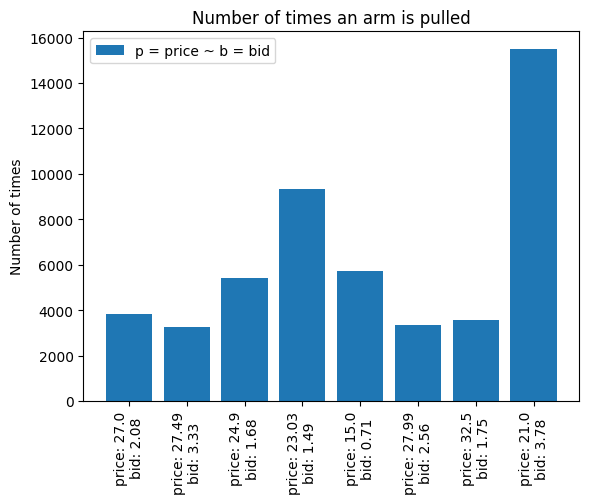

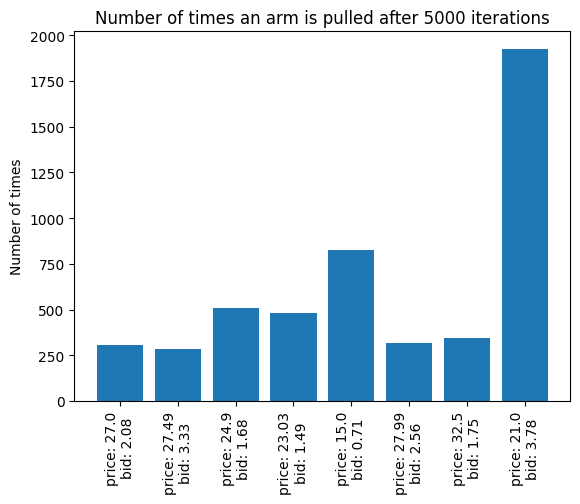

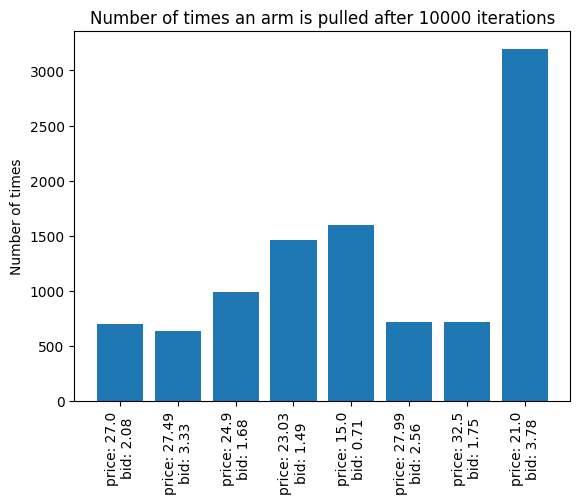

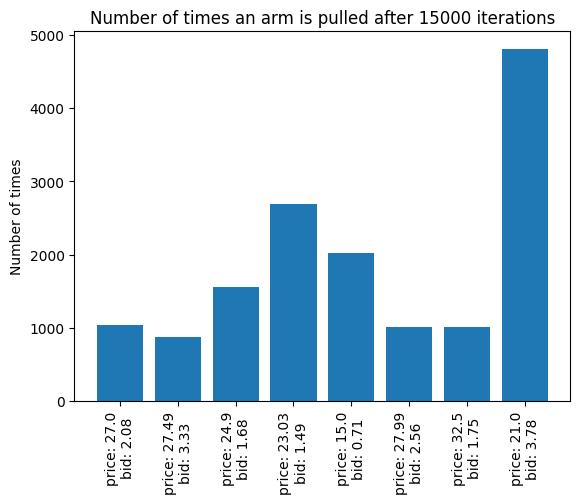

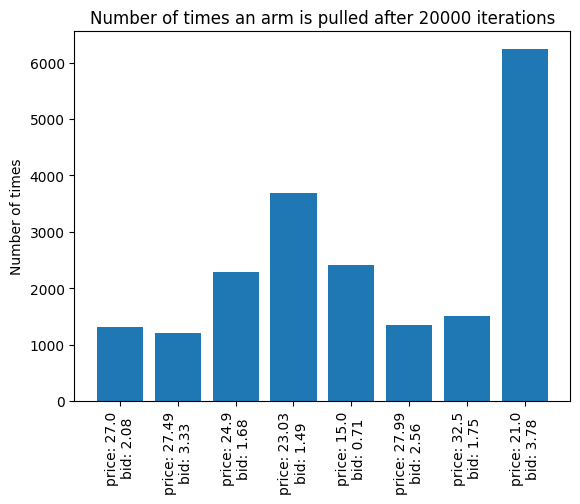

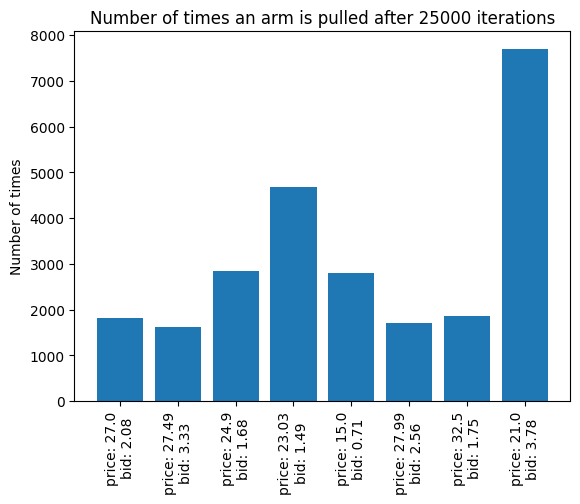

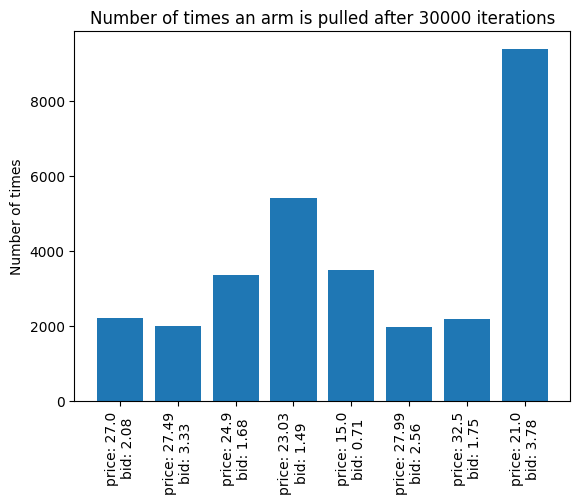

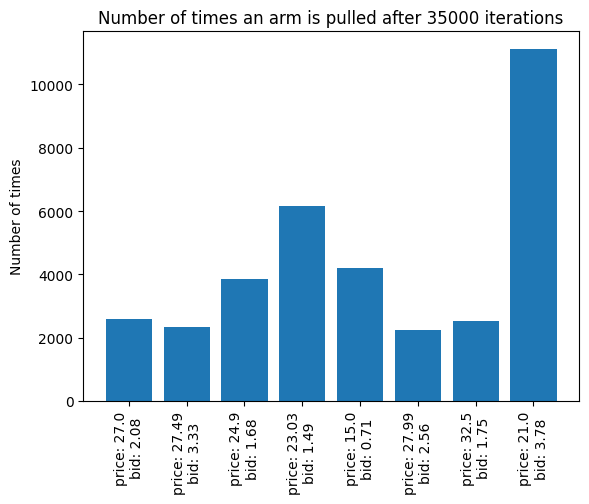

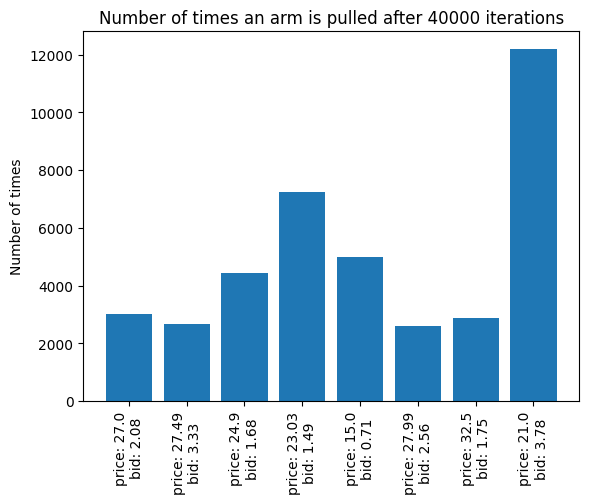

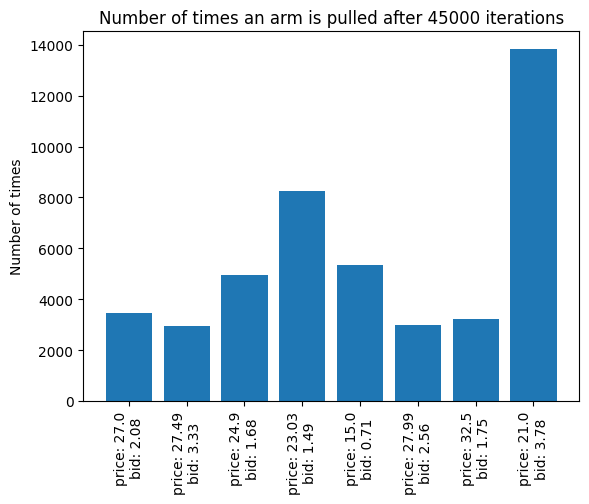

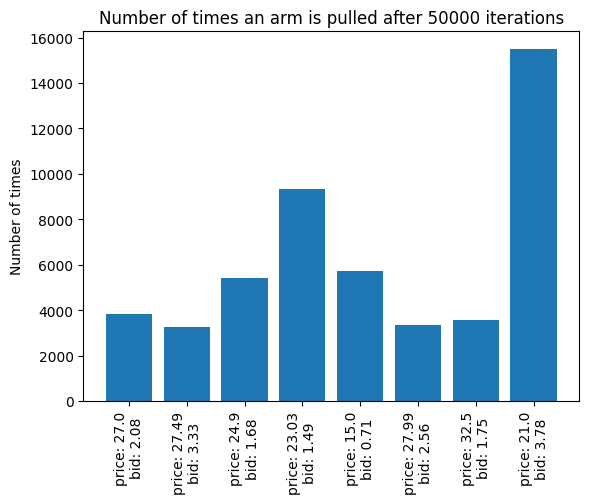

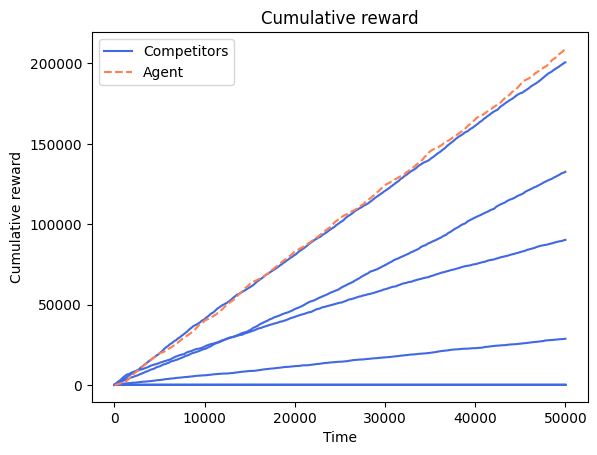

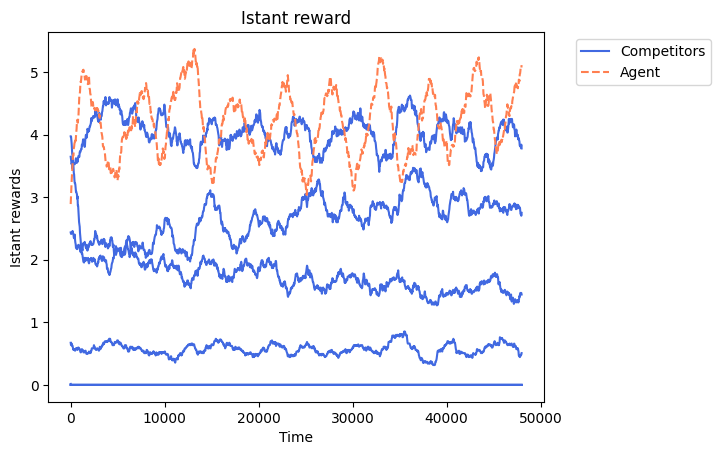

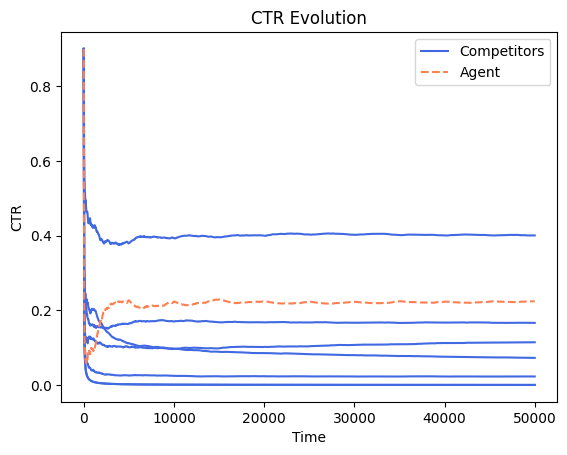

In [5]:
#execution_exp3("Test_finali_mean/variable_UCB1_zaini_0.9","zaini",competitors,agents,chosen_arm,comp_id_win,rewards,ctr_list)

Discounted UCB1

In [20]:
list_rewards = []
#Environment
CTR = np.ones(20)
env1 = envv.Environment(4,len(competitors)+1,ut.allocation_mec,ut.user_gernator,CTR)

#MAB
maxrewards  = [agents[i].price - agents[i].bid for i in range(len(agents))]
mab0 = age.UCB1_Discounted_Agent(len(agents),maxrewards,0.9)
saved_user = [] #mi serve per il calcolo ella regret
rewards = [] #mi serve per calcolarmi le reward ad ogni t per il calcolo della regret
slots = [] #mi serve per vedere lo slot occupato dall'agent
attract = [] #lo uso per vedere se attr è alto è dell agent e agent viene contemporaneamente selezionato
prints = [] #lista che uso per salvarmi le prints per poi stamparle su foglio .txt
chosen_arm = [] #mi serve per fare i plot sugli arm
full_rewards = [] #lsita che diventerà matrice dove mettere tutte le rewards per poi fare il calcolo della policy regret, che lo faccio conforntando con il vettore rewards,e posso fare anche lo sliding window.


for i in range(50000):
    index_agent_pulled_arm = mab0.pull_arm_window()
    reward = env1.step(competitors,agents[index_agent_pulled_arm])
    mab0.update(reward[0])
    rewards.append(reward[0])
    saved_user.append(reward[3])   #mi salvo ogni volta lo user generato in modo dopo da poter fare la siulazione per calcolo regret
    slots.append(reward[4])        #mi salvo lo slot di appartenza dell 'agent, se presente (in quelli visualizzati dallo user)
    attract.append(reward[5])
    prints.append(reward[6])
    chosen_arm.append(index_agent_pulled_arm)
    full_rewards.append(full_rewards_fun(agents,env1.CTR,competitors,saved_user,index_agent_pulled_arm,reward))

/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:289: RuntimeWarning: divide by zero encountered in log
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:289: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:289: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:289: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]


EXP3

In [5]:
list_rewards = []
#Environment
CTR = np.ones(10)
env1 = envv.Environment(5,len(competitors)+1,ut.allocation_mec,ut.user_gernator,CTR)

#MAB
maxrewards  = [agents[i].price - agents[i].bid for i in range(len(agents))]
mab0 = age.Exp3Agent(len(agents),maxrewards,1)
saved_user = [] #mi serve per il calcolo ella regret
rewards = [] #mi serve per calcolarmi le reward ad ogni t per il calcolo della regret
slots = [] #mi serve per vedere lo slot occupato dall'agent
attract = [] #lo uso per vedere se attr è alto è dell agent e agent viene contemporaneamente selezionato
prints = [] #lista che uso per salvarmi le prints per poi stamparle su foglio .txt
chosen_arm = [] #mi serve per fare i plot sugli arm
full_rewards = [] #lsita che diventerà matrice dove mettere tutte le rewards per poi fare il calcolo della policy regret, che lo faccio conforntando con il vettore rewards,e posso fare anche lo sliding window.
ctr_list = []
comp_id_win = []



for i in range(50000):
    index_agent_pulled_arm = mab0.pull_arm()
    reward = env1.step(competitors,agents[index_agent_pulled_arm])
    mab0.update(reward)
    rewards.append(reward[0])
    saved_user.append(reward[3])   #mi salvo ogni volta lo user generato in modo dopo da poter fare la siulazione per calcolo regret
    slots.append(reward[4])        #mi salvo lo slot di appartenza dell 'agent, se presente (in quelli visualizzati dallo user)
    attract.append(reward[5])
    prints.append(reward[6])
    chosen_arm.append(index_agent_pulled_arm)
    full_rewards.append(full_rewards_fun(agents,env1.CTR,competitors,saved_user,index_agent_pulled_arm,reward))
    ctr_list.append(copy.deepcopy(env1.CTR))
    comp_id_win.append(reward[2])

In [16]:
mab0.avg_reward

array([276.64679707, 441.23144893, 230.78455882, 323.1456196 ,
       371.71850467, 372.32608525, 394.19958606, 295.21492843,
       216.33976834])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/test/Desktop/Magistrale/Tesi/CODE/Test_finali_5x2/New_algo_2.0_zanini_0.3/xiaomi_arms_plot.tex'

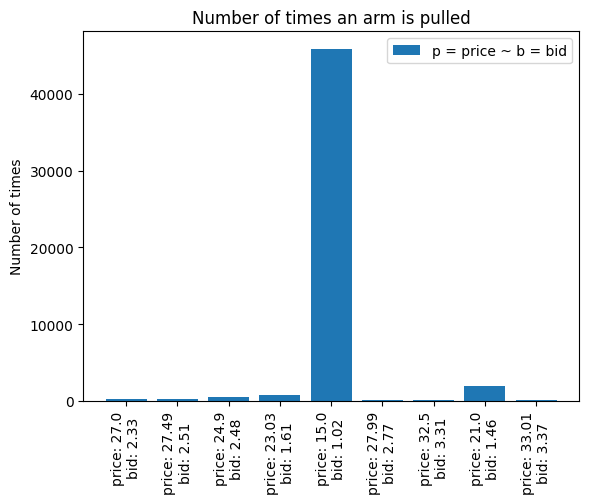

In [10]:
execution("Test_finali_5x2/New_algo_2.0_zanini_0.3","xiaomi",competitors,agents,chosen_arm,mab0.avg_reward,comp_id_win,rewards,ctr_list)


Variable Sliding Window UCB1 

In [29]:
list_rewards = []
#Environment
CTR = np.ones(20)
env1 = envv.Environment(4,len(competitors)+1,ut.allocation_mec,ut.user_gernator,CTR)

#MAB
maxrewards  = [agents[i].price - agents[i].bid for i in range(len(agents))]
mab0 = age.UCB1_Variable_Sliding_Window_Variation_Agent(len(agents),maxrewards,5000,7000,3000,100,3,5)
saved_user = [] #mi serve per il calcolo ella regret
rewards = [] #mi serve per calcolarmi le reward ad ogni t per il calcolo della regret
slots = [] #mi serve per vedere lo slot occupato dall'agent
attract = [] #lo uso per vedere se attr è alto è dell agent e agent viene contemporaneamente selezionato
prints = [] #lista che uso per salvarmi le prints per poi stamparle su foglio .txt
chosen_arm = [] #mi serve per fare i plot sugli arm
full_rewards = [] #lsita che diventerà matrice dove mettere tutte le rewards per poi fare il calcolo della policy regret, che lo faccio conforntando con il vettore rewards,e posso fare anche lo sliding window.


for i in range(50000):
    index_agent_pulled_arm = mab0.pull_arm_window()
    reward = env1.step(competitors,agents[index_agent_pulled_arm])
    mab0.update(reward[0])
    rewards.append(reward[0])
    saved_user.append(reward[3])   #mi salvo ogni volta lo user generato in modo dopo da poter fare la siulazione per calcolo regret
    slots.append(reward[4])        #mi salvo lo slot di appartenza dell 'agent, se presente (in quelli visualizzati dallo user)
    attract.append(reward[5])
    prints.append(reward[6])
    chosen_arm.append(index_agent_pulled_arm)
    full_rewards.append(full_rewards_fun(agents,env1.CTR,competitors,saved_user,index_agent_pulled_arm,reward))

/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:167: RuntimeWarning: divide by zero encountered in log
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:167: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:167: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]


Tau aggiornato positivi 4900
Tau aggiornato alternato 5000
Tau aggiornato alternato 5100
Tau aggiornato alternato 5200
Tau aggiornato positivi 5100
Tau aggiornato positivi 5000
Tau aggiornato positivi 4900
Tau aggiornato positivi 4800
Tau aggiornato positivi 4700
Tau aggiornato positivi 4600
Tau aggiornato positivi 4500
Tau aggiornato positivi 4400
Tau aggiornato positivi 4300
Tau aggiornato positivi 4200
Tau aggiornato positivi 4100
Tau aggiornato positivi 4000
Tau aggiornato positivi 3900
Tau aggiornato positivi 3800
Tau aggiornato positivi 3700
Tau aggiornato positivi 3600
Tau aggiornato positivi 3500
Tau aggiornato alternato 3600
Tau aggiornato positivi 3500
Tau aggiornato positivi 3400
Tau aggiornato positivi 3300
Tau aggiornato positivi 3200
Tau aggiornato positivi 3100
Tau aggiornato positivi 3000
Tau aggiornato alternato 3100
Tau aggiornato positivi 3000
Tau aggiornato alternato 3100
Tau aggiornato positivi 3000
Tau aggiornato alternato 3100
Tau aggiornato alternato 3200
Tau ag

Variable Discounted UCB1

In [37]:
list_rewards = []
#Environment
CTR = np.ones(20)
env1 = envv.Environment(4,len(competitors)+1,ut.allocation_mec,ut.user_gernator,CTR)

#MAB
maxrewards  = [agents[i].price - agents[i].bid for i in range(len(agents))]
mab0 = age.UCB1_Variable_discounted__Variation_Agent(len(agents),maxrewards,0.8,0.95,0.4,0.02,3,5)
saved_user = [] #mi serve per il calcolo ella regret
rewards = [] #mi serve per calcolarmi le reward ad ogni t per il calcolo della regret
slots = [] #mi serve per vedere lo slot occupato dall'agent
attract = [] #lo uso per vedere se attr è alto è dell agent e agent viene contemporaneamente selezionato
prints = [] #lista che uso per salvarmi le prints per poi stamparle su foglio .txt
chosen_arm = [] #mi serve per fare i plot sugli arm
full_rewards = [] #lsita che diventerà matrice dove mettere tutte le rewards per poi fare il calcolo della policy regret, che lo faccio conforntando con il vettore rewards,e posso fare anche lo sliding window.


for i in range(50000):
    index_agent_pulled_arm = mab0.pull_arm_window()
    reward = env1.step(competitors,agents[index_agent_pulled_arm])
    mab0.update(reward[0])
    rewards.append(reward[0])
    saved_user.append(reward[3])   #mi salvo ogni volta lo user generato in modo dopo da poter fare la siulazione per calcolo regret
    slots.append(reward[4])        #mi salvo lo slot di appartenza dell 'agent, se presente (in quelli visualizzati dallo user)
    attract.append(reward[5])
    prints.append(reward[6])
    chosen_arm.append(index_agent_pulled_arm)
    full_rewards.append(full_rewards_fun(agents,env1.CTR,competitors,saved_user,index_agent_pulled_arm,reward))

/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:350: RuntimeWarning: divide by zero encountered in log
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:350: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:350: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:350: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]


Tau aggiornato alternato 0.8200000000000001
Tau aggiornato alternato 0.8400000000000001
Tau aggiornato alternato 0.8600000000000001
Tau aggiornato alternato 0.8800000000000001
Tau aggiornato alternato 0.9000000000000001
Tau aggiornato positivi 0.8800000000000001
Tau aggiornato alternato 0.9000000000000001
Tau aggiornato alternato 0.9200000000000002
Tau aggiornato alternato 0.9400000000000002
Tau aggiornato alternato 0.9600000000000002
Tau aggiornato positivi 0.9400000000000002
Tau aggiornato alternato 0.9600000000000002
Tau aggiornato positivi 0.9400000000000002
Tau aggiornato alternato 0.9600000000000002
Tau aggiornato positivi 0.9400000000000002
Tau aggiornato alternato 0.9600000000000002
Tau aggiornato positivi 0.9400000000000002
Tau aggiornato positivi 0.9200000000000002
Tau aggiornato alternato 0.9400000000000002
Tau aggiornato alternato 0.9600000000000002
Tau aggiornato positivi 0.9400000000000002
Tau aggiornato alternato 0.9600000000000002
Tau aggiornato positivi 0.9400000000000

Boosted UCB1

In [9]:
list_rewards = []
#Environment
CTR = np.ones(20)
env1 = envv.Environment(4,len(competitors)+1,ut.allocation_mec,ut.user_gernator,CTR)

#MAB
maxrewards  = [agents[i].price - agents[i].bid for i in range(len(agents))]
mab0 = age.UCB1Agent_adaptive(len(agents),maxrewards,2)
saved_user = [] #mi serve per il calcolo ella regret
rewards = [] #mi serve per calcolarmi le reward ad ogni t per il calcolo della regret
slots = [] #mi serve per vedere lo slot occupato dall'agent
attract = [] #lo uso per vedere se attr è alto è dell agent e agent viene contemporaneamente selezionato
prints = [] #lista che uso per salvarmi le prints per poi stamparle su foglio .txt
chosen_arm = [] #mi serve per fare i plot sugli arm
full_rewards = [] #lsita che diventerà matrice dove mettere tutte le rewards per poi fare il calcolo della policy regret, che lo faccio conforntando con il vettore rewards,e posso fare anche lo sliding window.



for i in range(50000):
    index_agent_pulled_arm = mab0.pull_arm()
    reward = env1.step(competitors,agents[index_agent_pulled_arm])
    mab0.update(reward[0],env1.CTR[-1],len(competitors)+1)
    mab0.update_real(reward[0])
    rewards.append(reward[0])
    saved_user.append(reward[3])   #mi salvo ogni volta lo user generato in modo dopo da poter fare la siulazione per calcolo regret
    slots.append(reward[4])        #mi salvo lo slot di appartenza dell 'agent, se presente (in quelli visualizzati dallo user)
    attract.append(reward[5])
    prints.append(reward[6])
    chosen_arm.append(index_agent_pulled_arm)
    full_rewards.append(full_rewards_fun(agents,env1.CTR,competitors,saved_user,index_agent_pulled_arm,reward))
        

/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:491: RuntimeWarning: divide by zero encountered in log
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:491: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:491: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]
/Users/test/Desktop/Magistrale/Tesi/CODE/JPBagents.py:491: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(2*np.log(self.t)/self.n_pulls[a]) for a in range(self.n_arms)]


Policy Regret

In [10]:
#questo sulle non sliding dovrei aggiustarlo perchè non va bene che il ctr sia sempre 1 ad ogi iterazione ma deve essere quelleo reale

In [58]:
rewards_arms = [] #diverso da full rewards, perchè questo lo uso per il calolo standard della cum regre, vettore di 20 elementi dove ogni elemento è una lista di reward quindi riesco a capire quale ha la cumulativ epiù alta
       
for arm in range(len(agents)):
    CTR = np.ones(20)
    env1 = reg.Environment(4,len(competitors),ut.allocation_mec_regret,saved_user,CTR)
    reward_arm = []
    for counter in range(50000):
        index_agent_pulled_arm = arm
        reward = env1.step(competitors,agents[arm],counter)
        reward_arm.append(reward[0])

    rewards_arms.append(reward_arm)


In [4]:

#stability
rewards_arms = [] #diverso da full rewards, perchè questo lo uso per il calolo standard della cum regre, vettore di 20 elementi dove ogni elemento è una lista di reward quindi riesco a capire quale ha la cumulativ epiù alta
       
       
for arm in range(len(competitors)):
    CTR = np.ones(19)
    env1 = stab.Environment(4,len(competitors)+1,ut.allocation_mec_stability,ut.user_gernator,CTR)
    reward_arm = []
    for counter in range(50000):
        reward = env1.step(competitors)

    rewards_arms.append(reward_arm)

In [6]:
best_index = find_best_arm(rewards_arms)
cum_slide = sliding_cumulative_regret_values(rewards_arms,50000)
best_indexes_windows = sli_cum_reg_index_and_values(10,cum_slide)
res = rew_counter(rewards,attract)
#mab0.avg_reward

In [3]:
#Ogni esecuzione devo fare check di:
#average rewards in modo da cambiare i ticks di visualizzazione nel plot avg reward
#i nomi dei product
#il nome della cartella dove mettere le imm e fare il multipdf
#nome_file_output anche cambiare
#creare cartella dove metter epdfs



[ 162045.84        309974.05        477544.18        629769.06000001
  777697.27000002  931763.58000004 1063732.73000005 1195088.07000006
 1333195.32000007 1463936.85000008 1593450.7600001  1715598.95000011
 1839588.57000012 1975240.58000013 2104140.68000014 2221992.20000015
 2352119.92000016 2471199.06000018 2585367.72000019 2698922.5700002
 2819229.33000021 2943218.95000022 3067208.57000023 3195494.86000024
 3324394.96000025 3461274.59000027 3582195.16000028 3713550.50000029
 3844292.0300003  3968895.46000031 4083064.12000032 4200301.83000033
 4319994.78000025 4447053.45000016 4564904.97000008 4690122.21
 4827001.83999991 4943011.92999983 5065773.92999975 5191604.97999967
 5315594.59999958 5426694.20999951 5548228.58999943 5668535.34999935
 5794366.39999926 5910376.48999919 6026386.57999911 6148534.76999903
 6276821.05999894 6395286.38999886]
[  23913.52         49393.37         76522.51        111948.07
  141770.61        171677.26        200953.2         227835.2
  258193.88       

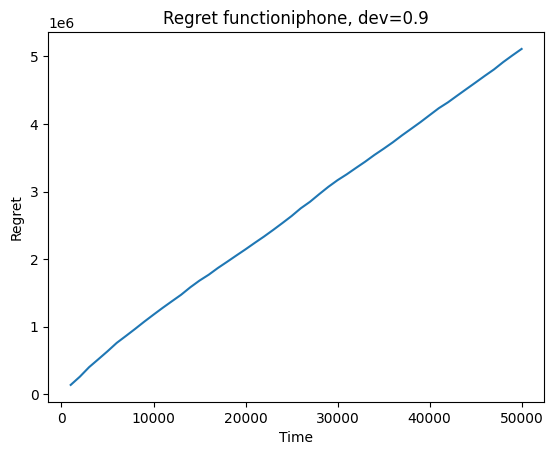

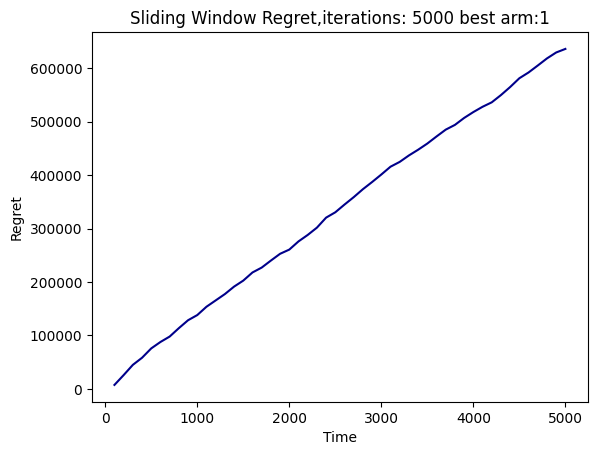

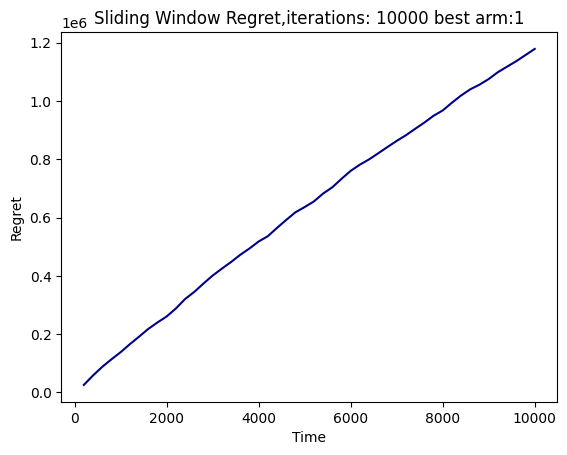

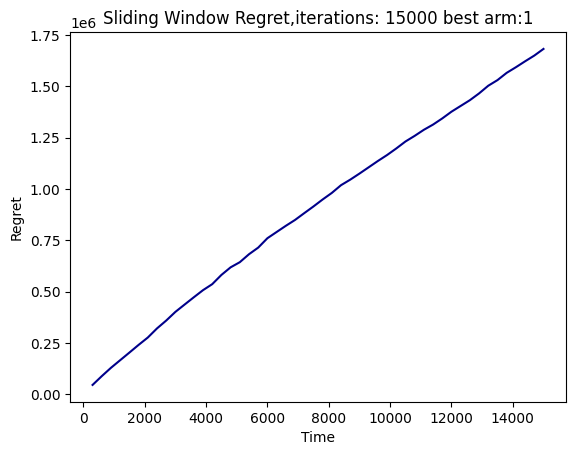

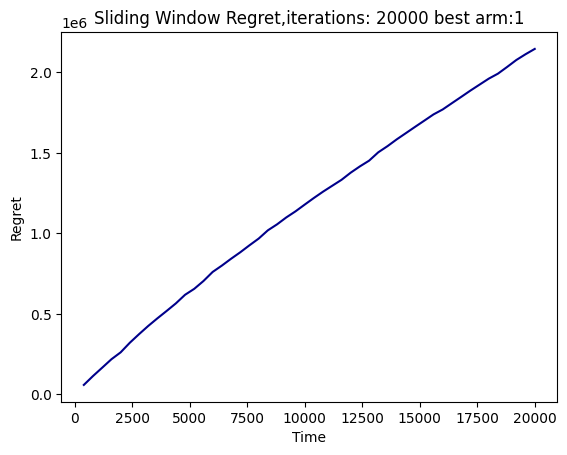

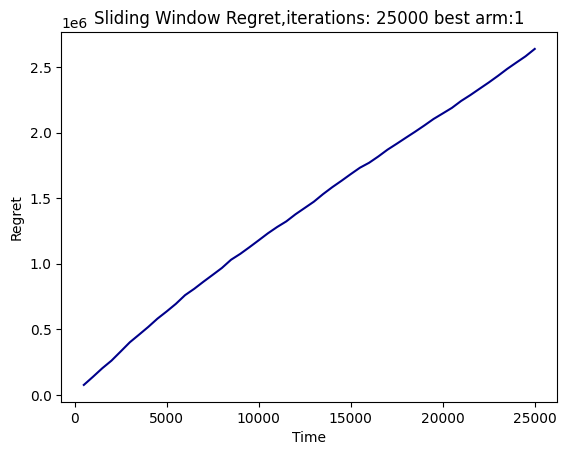

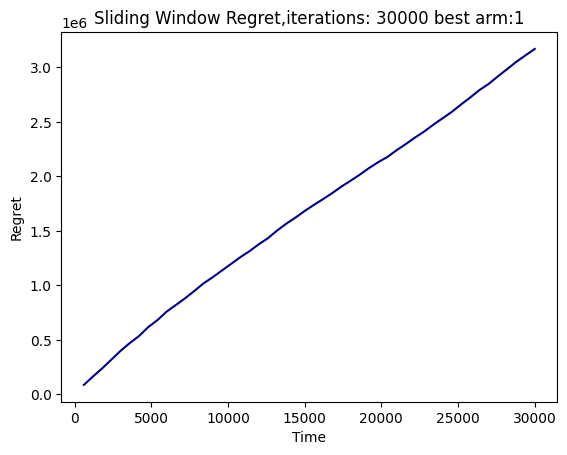

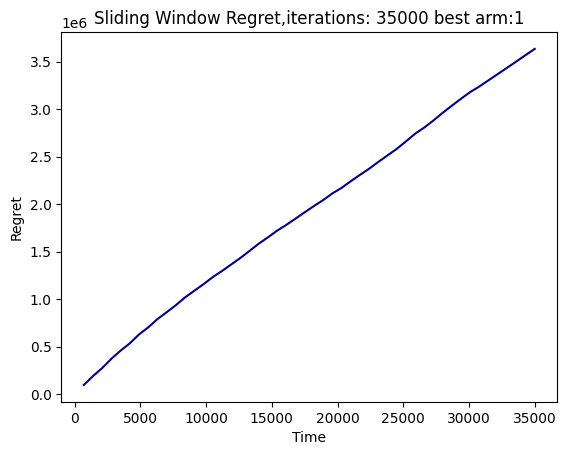

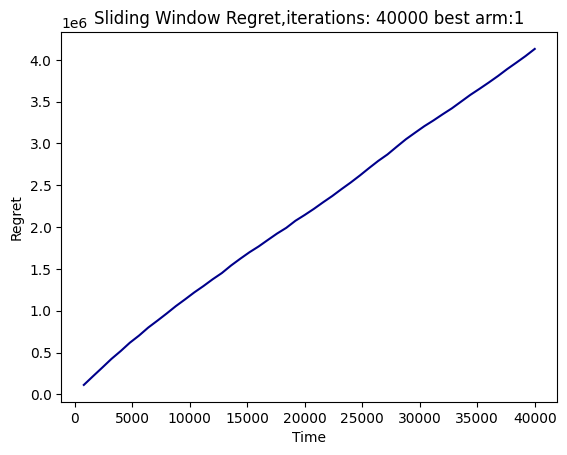

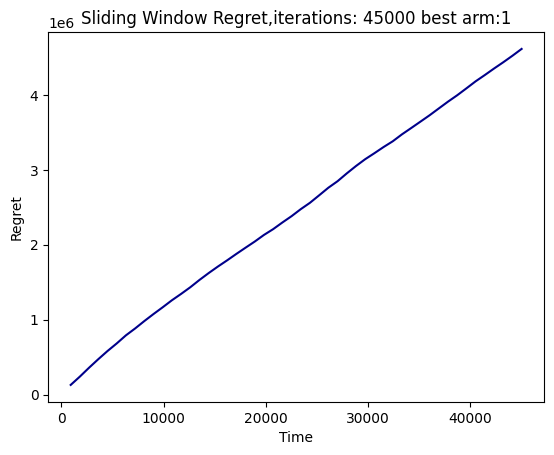

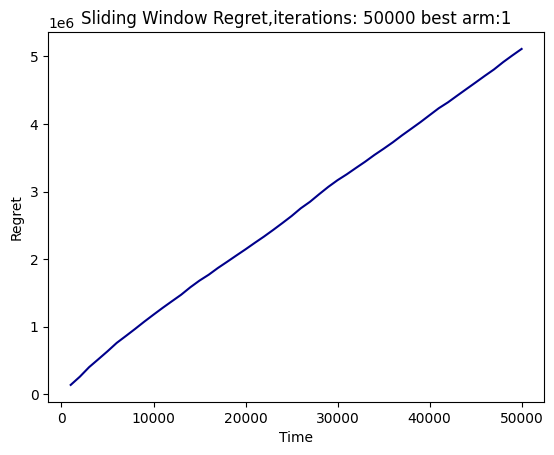

[  66506.22        109547.11        163774.71        217524.36
  260725.38        318686.67        387745.49        448156.54
  500732.59        560349.25000001  618566.45000001  674704.36000001
  756162.19000001  842600.18000001  936452.96       1010063.36
 1095274.3        1170301.36999999 1218674.11999999 1265849.02999999
 1310570.46999998 1354111.01999998 1408853.24999998 1456299.33999997
 1516024.53999998 1578268.69999998 1626714.65999998 1687029.83999998
 1733070.86999998 1787543.88999999 1841253.86999999 1893581.16999999
 1947351.16       2003659.83       2065748.42       2115205.58000001
 2171056.15000001 2213727.04000001 2270789.74000001 2321842.66000002
 2377032.90000002 2427433.57000003 2480804.96000003 2540288.44000004
 2595844.41000004 2638931.58000005 2693225.28000005 2756382.70000005
 2805082.72000006 2868331.00000006]


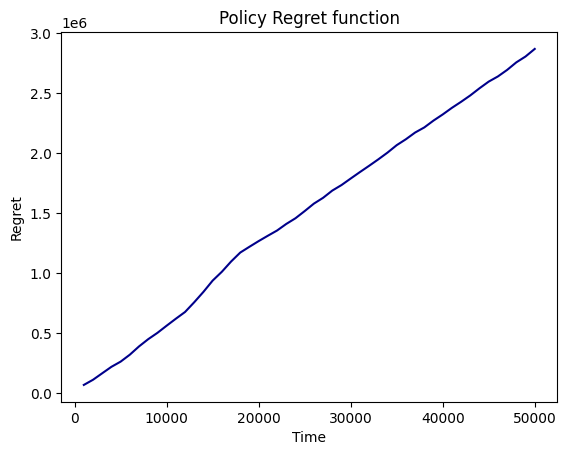

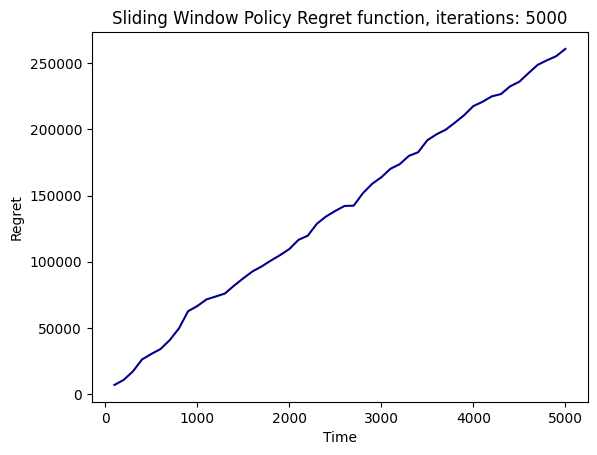

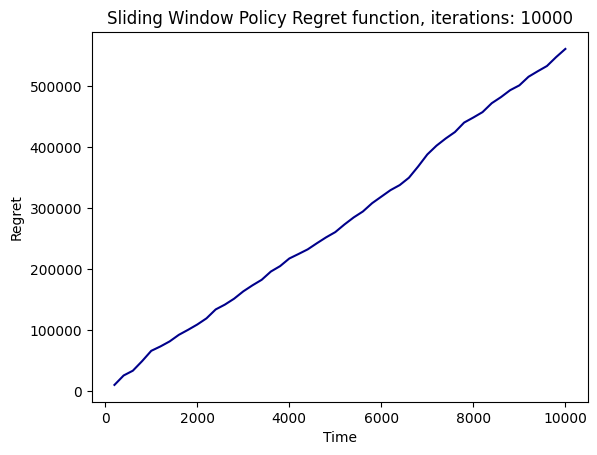

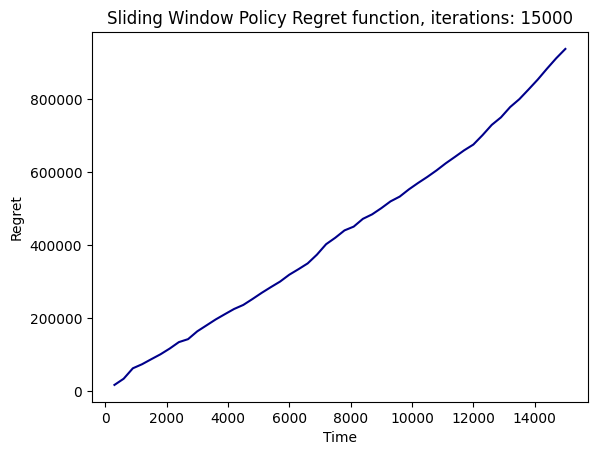

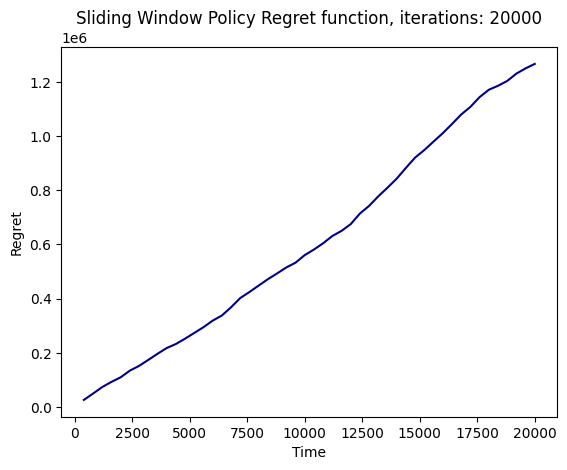

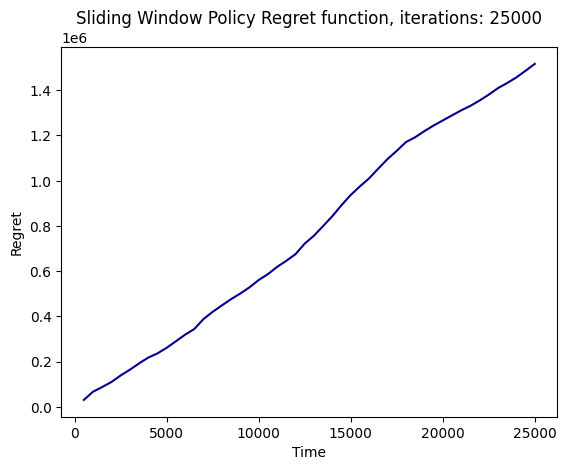

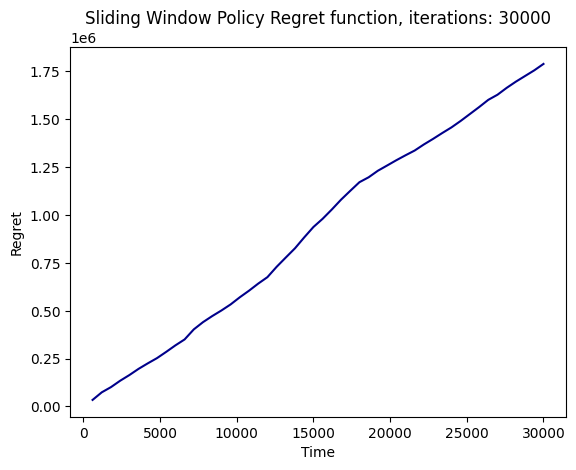

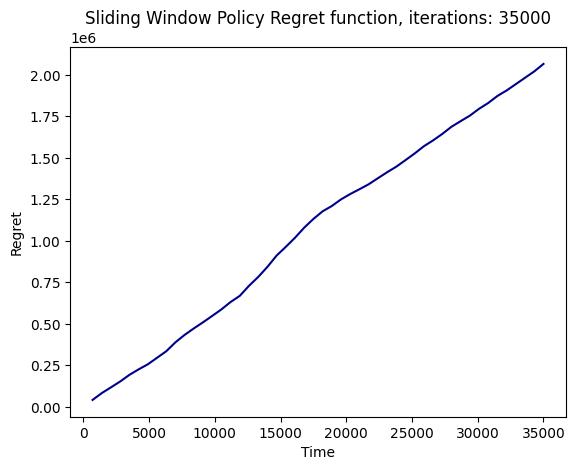

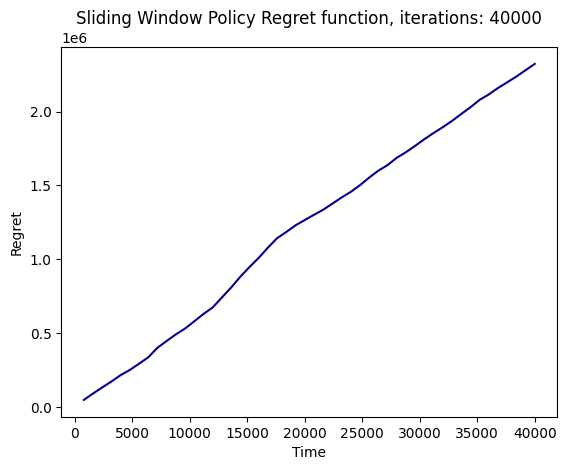

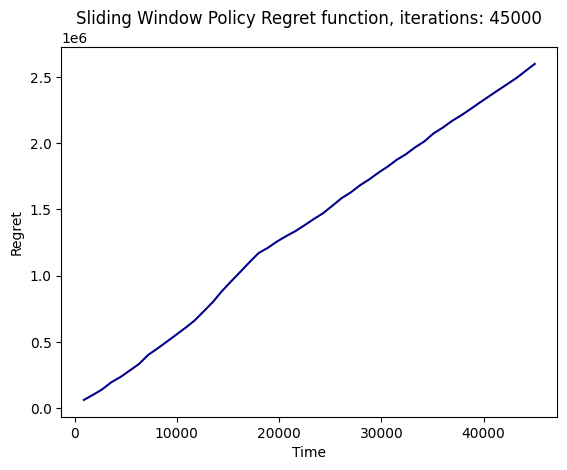

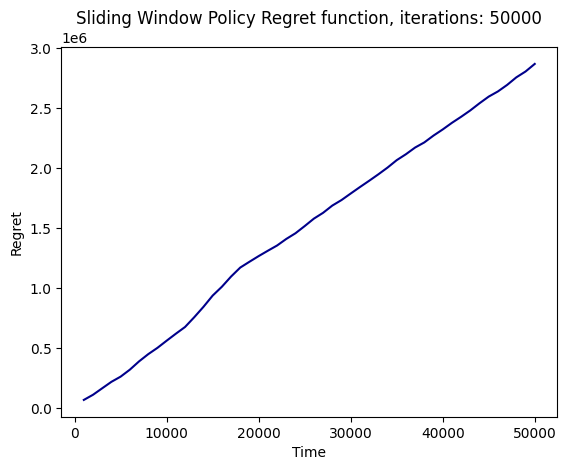

/var/folders/wr/q4dmj0xs4b1gqtf3lt70rcw40000gn/T/ipykernel_30327/3450172554.py:292: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_minor_formatter(tkr.FixedFormatter(mybins))
/var/folders/wr/q4dmj0xs4b1gqtf3lt70rcw40000gn/T/ipykernel_30327/3450172554.py:313: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_minor_formatter(tkr.FixedFormatter(mybins))
/var/folders/wr/q4dmj0xs4b1gqtf3lt70rcw40000gn/T/ipykernel_30327/3450172554.py:348: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_minor_formatter(tkr.FixedFormatter(mybins))


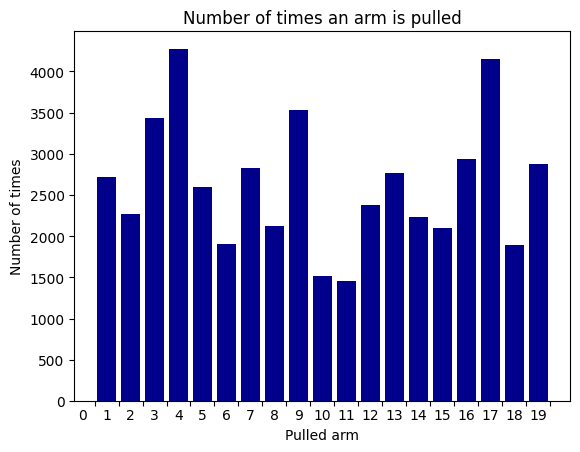

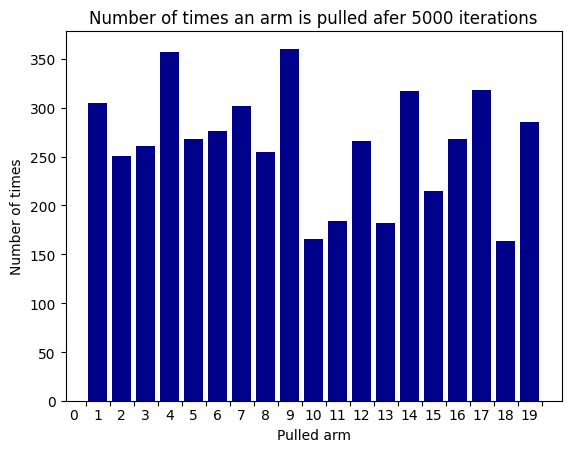

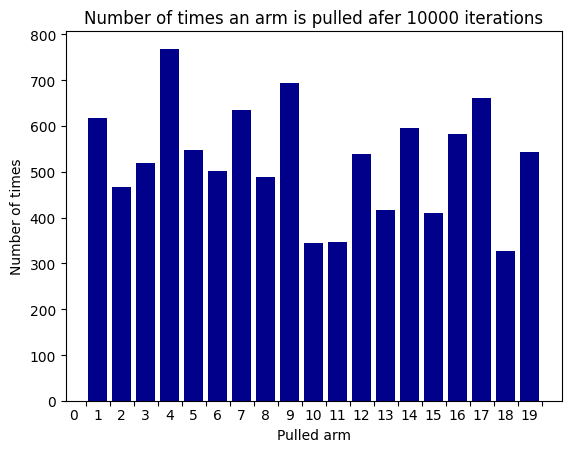

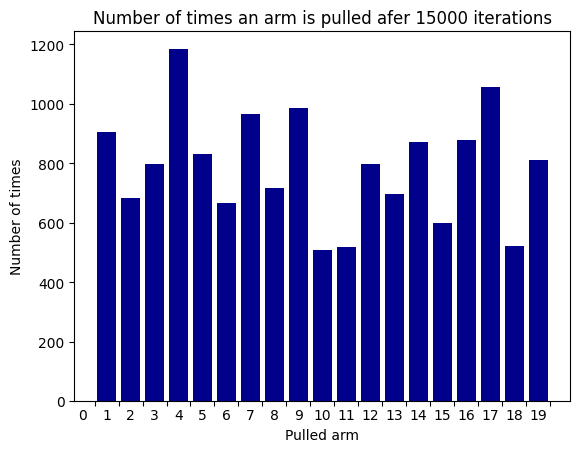

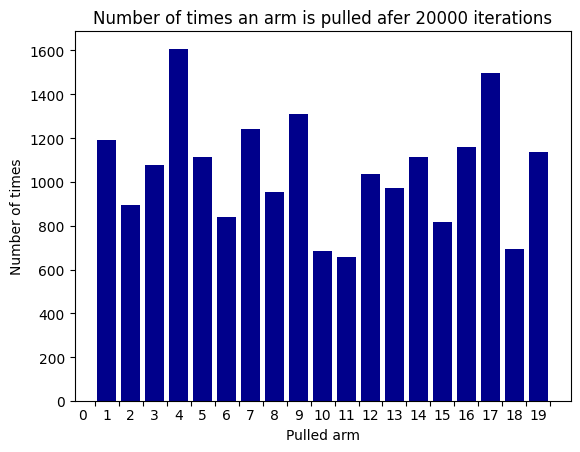

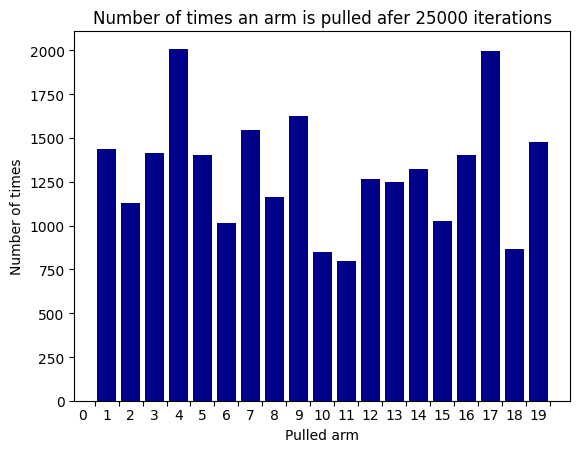

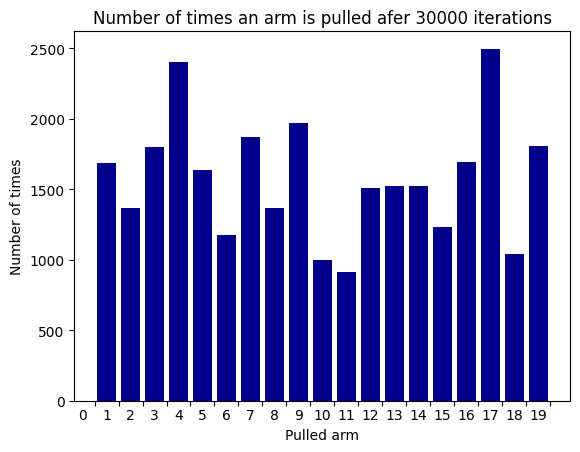

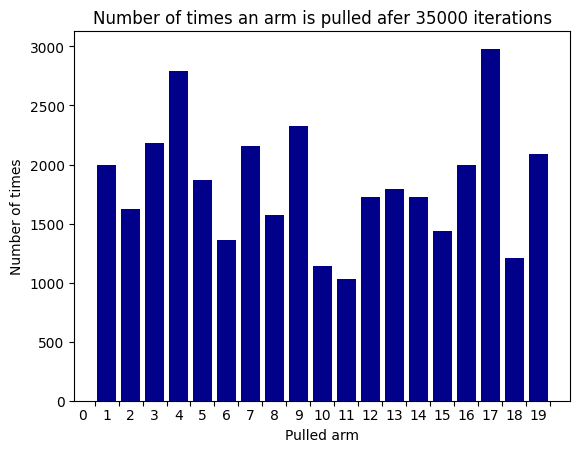

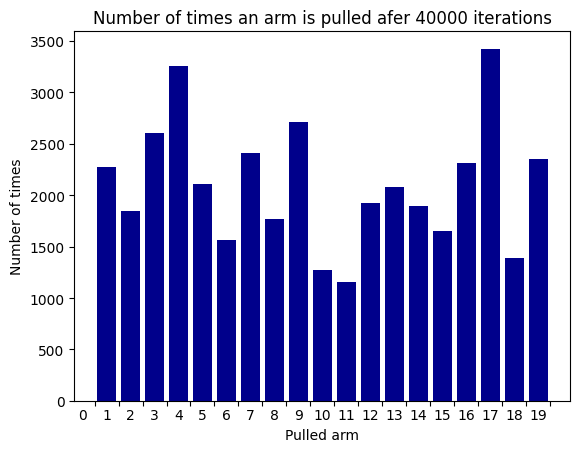

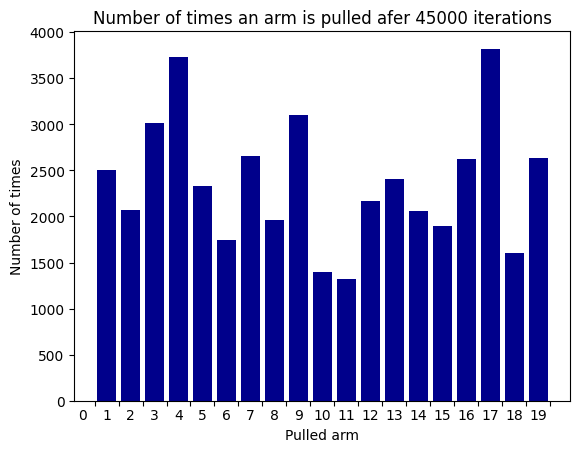

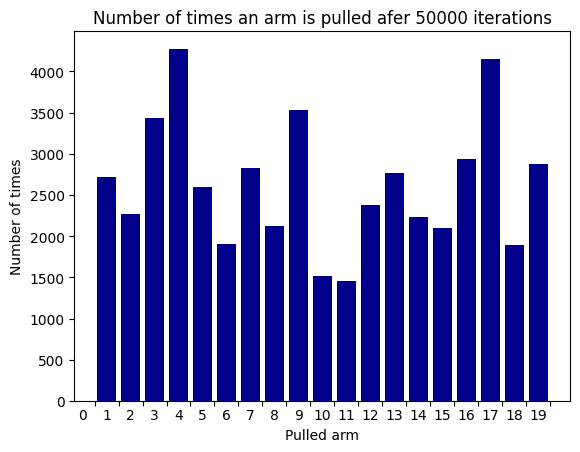

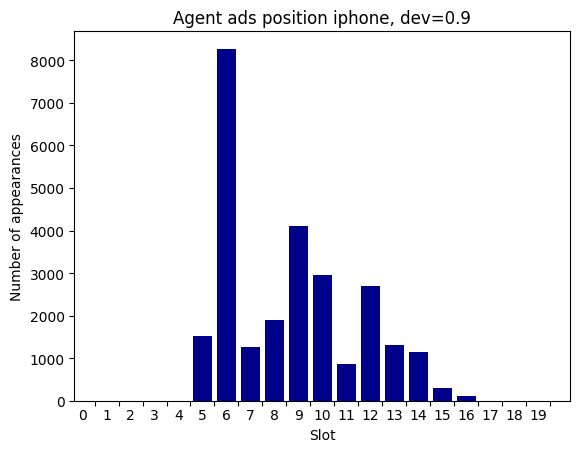

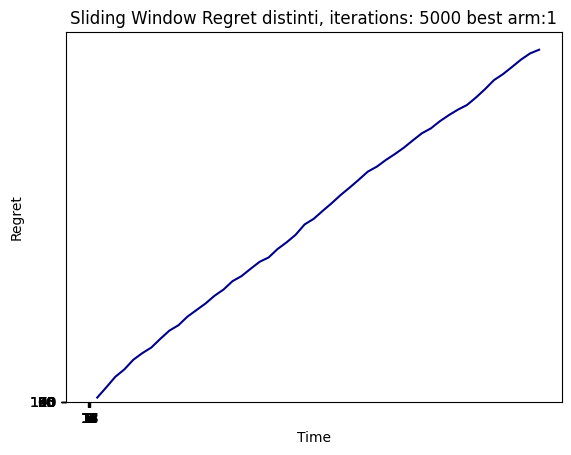

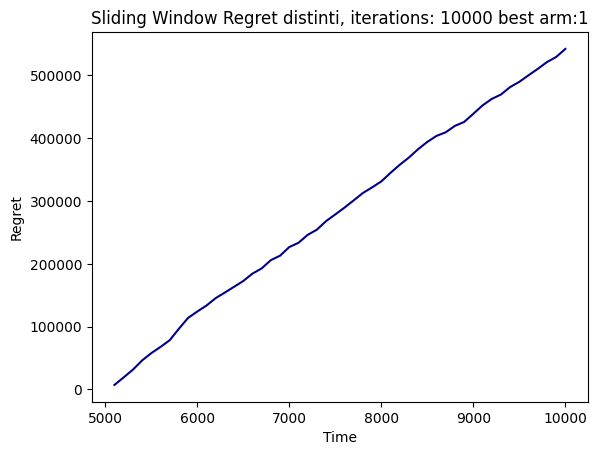

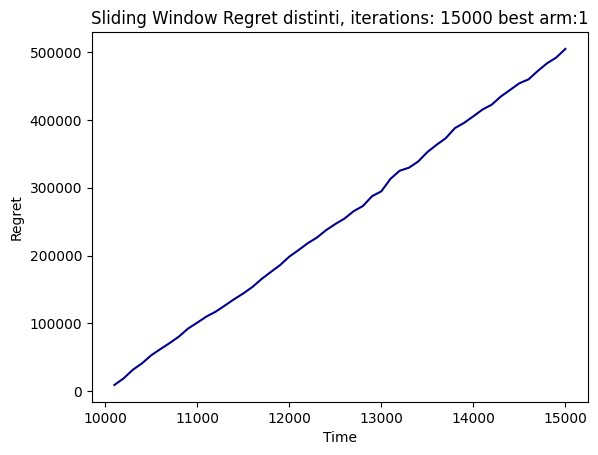

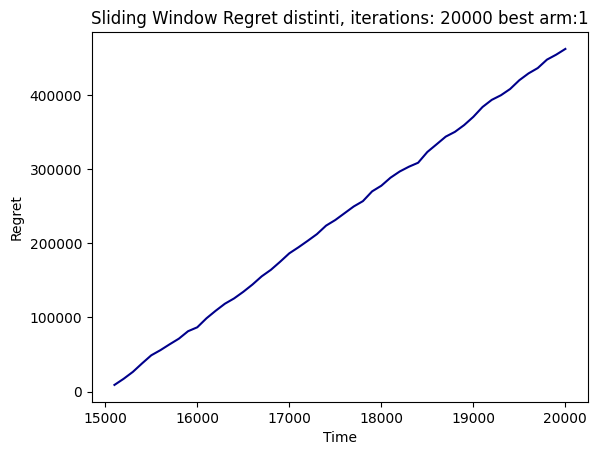

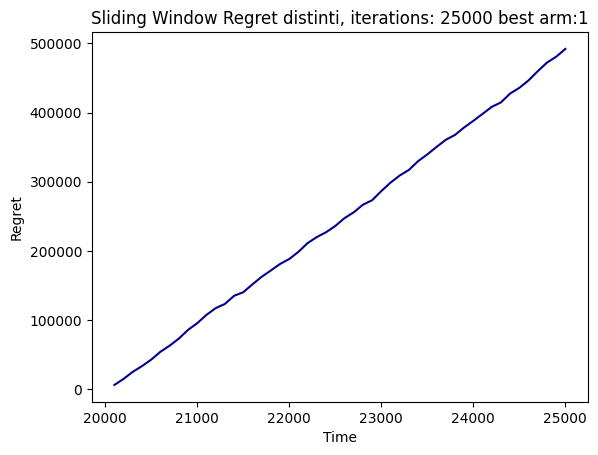

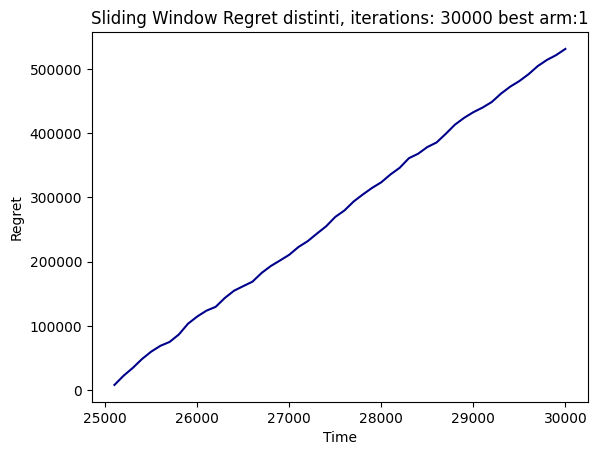

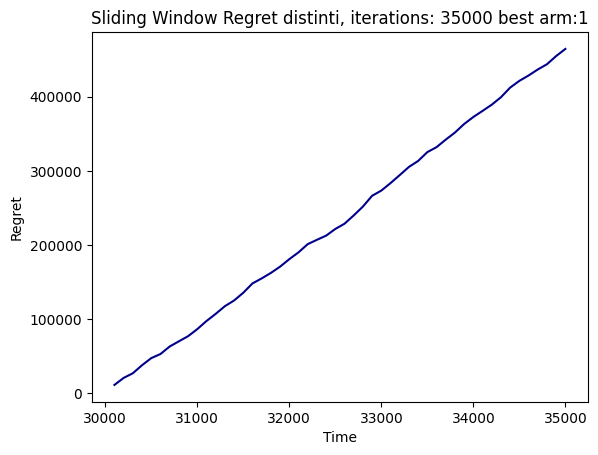

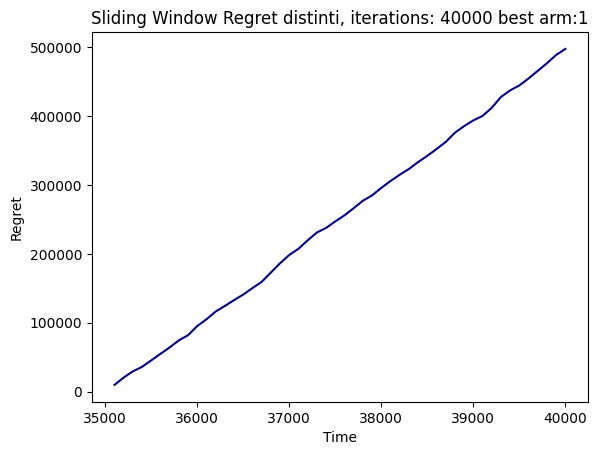

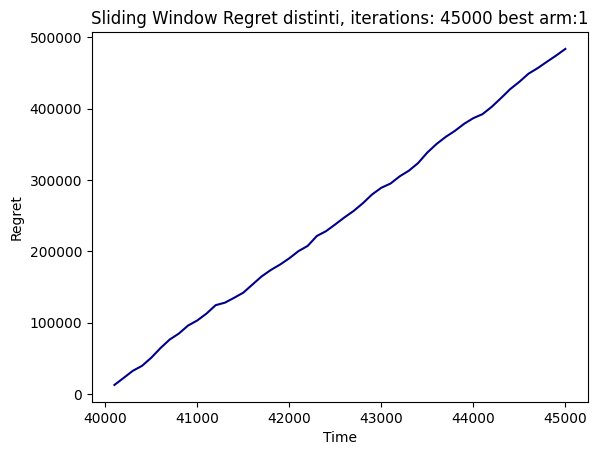

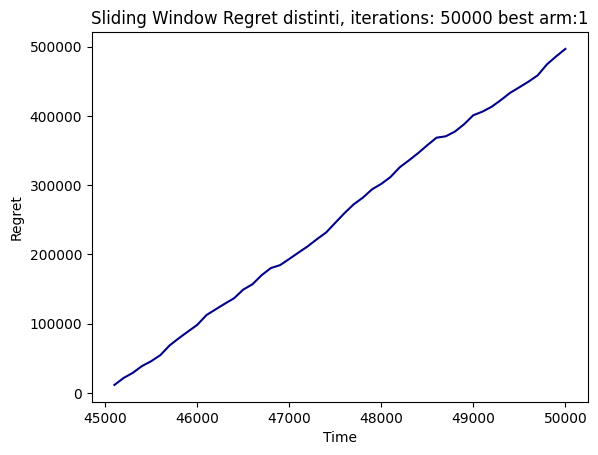

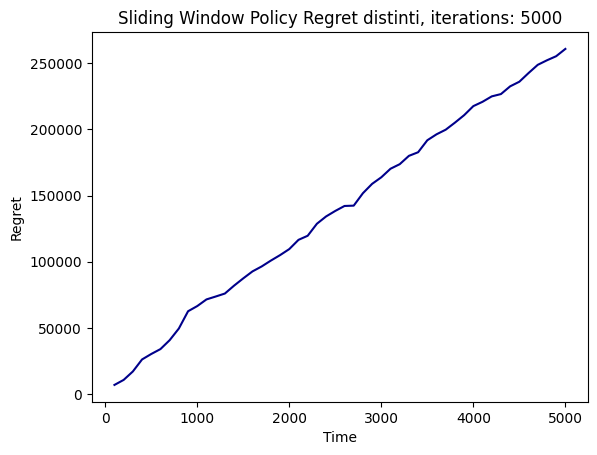

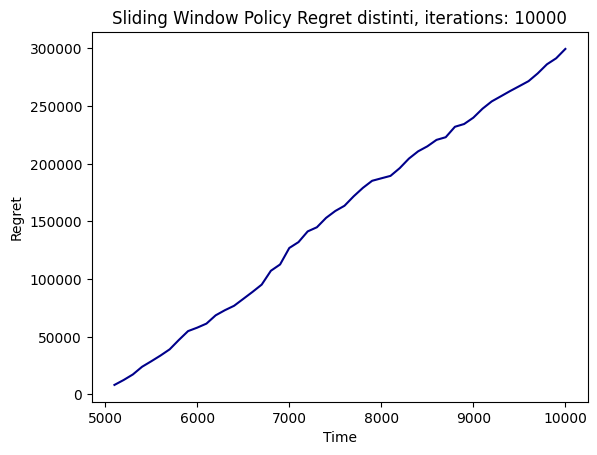

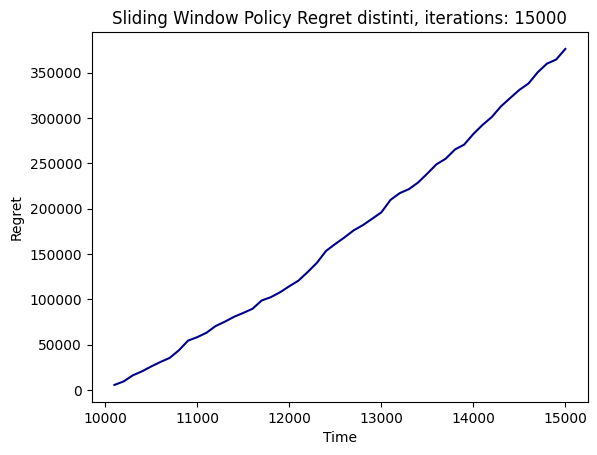

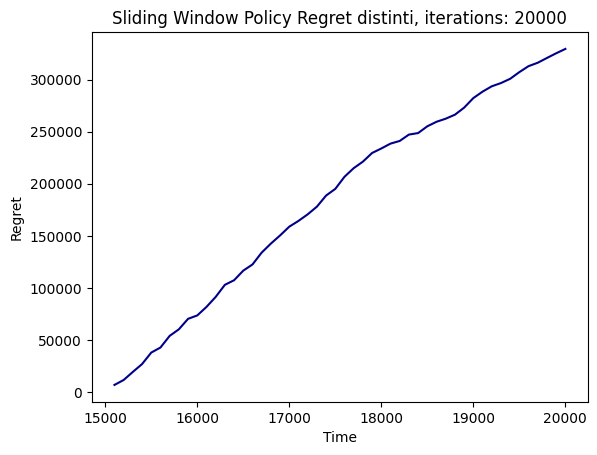

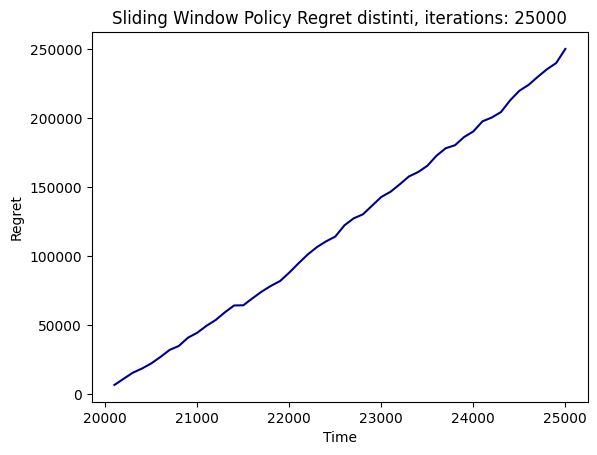

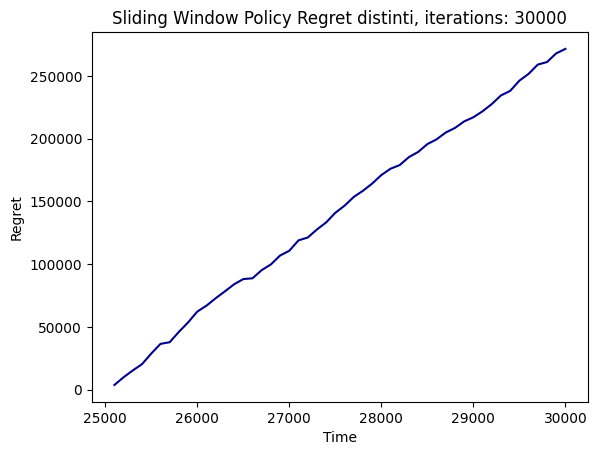

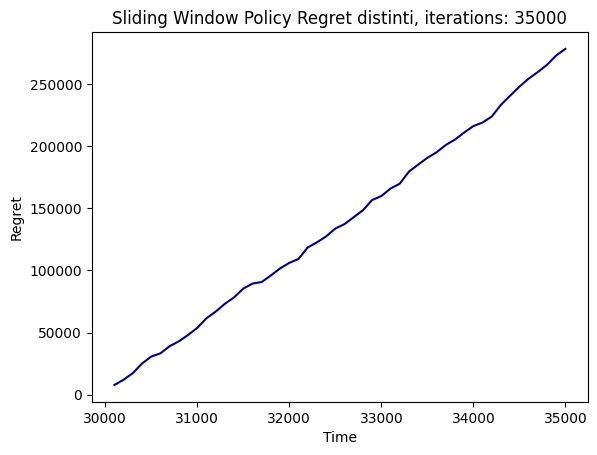

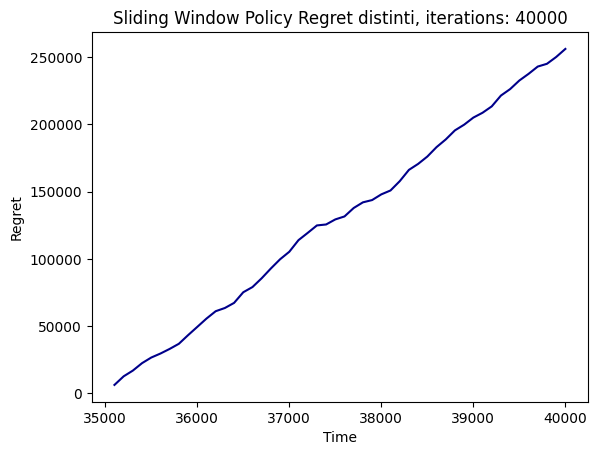

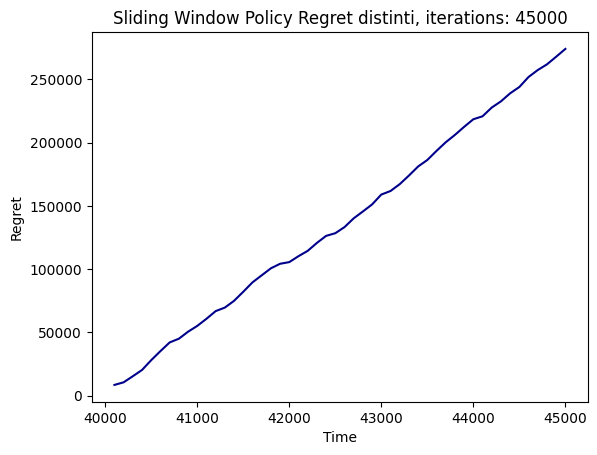

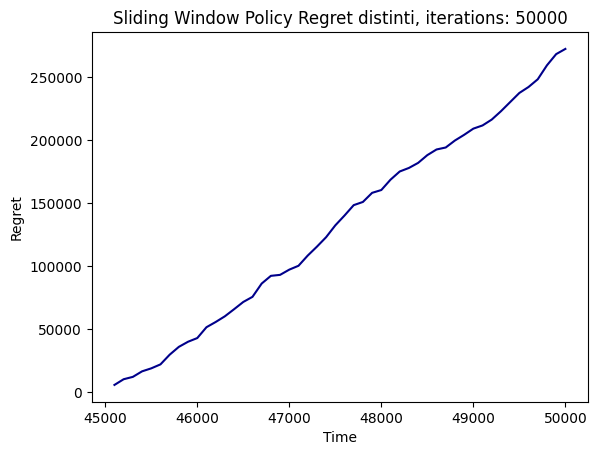

In [7]:
regret_plot(rewards,rewards_arms,best_index,"iphone, dev=0.9","new_algo_ctr_iphone_0.9_2")
regret_plot_windows(rewards,rewards_arms,best_indexes_windows,"iphone, dev=0.9","new_algo_ctr_iphone_0.9_2")
policy_regret_plot(full_rewards,rewards,"iphone, dev=0.9","new_algo_ctr_iphone_0.9_2")
policy_regret_plot_windows_plot(rewards,full_rewards,"iphone, dev=0.9","new_algo_ctr_iphone_0.9_2")
arms_plot(chosen_arm,"iphone, dev=0.9","new_algo_ctr_iphone_0.9_2")
arms_plot_windows(chosen_arm,"iphone, dev=0.9","new_algo_ctr_iphone_0.9_2")
slot_plot(slots,"iphone, dev=0.9","new_algo_ctr_iphone_0.9_2")
average_rewards_plot(mab0.avg_reward,"iphone, dev=0.9","new_algo_ctr_iphone_0.9_2")
#average_rewards_plot_boosted(mab0.avg_reward,"xiaomi, dev=0.9","xiaomi_0.9_correction")
regret_plot_windows_distinti(rewards,rewards_arms,best_indexes_windows,"iphone, dev=0.9","new_algo_ctr_iphone_0.9_2")
policy_regret_plot_windows_plot_distinti(rewards,full_rewards,"iphone, dev=0.9","new_algo_ctr_iphone_0.9_2")
pdf_creation("new_algo_ctr_iphone_0.9_2")
write_outputs("new_algo_ctr_iphone_0.9_2",prints)

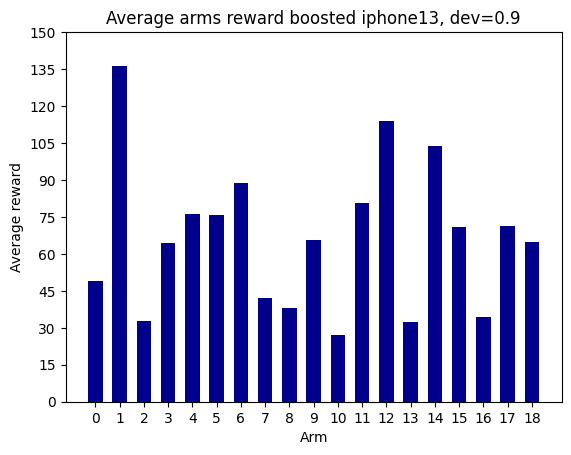

In [10]:
average_rewards_plot_boosted(mab0.avg_reward,"iphone13, dev=0.9","iphone_0.9_boosted_1.3")


In [126]:
def cumulative_rewards_plot(rewards):
    #times = [(i+1)*1000 for i in range(50)]
    times = [i for i  in range(50000)]
    x_axis = times
    y_axis = cumulative_rewards(rewards)
    plt.plot(x_axis, y_axis)
    plt.title('Cumulative reward')
    plt.xlabel('Time')
    plt.ylabel('Cumulative reward')
    plt.show()

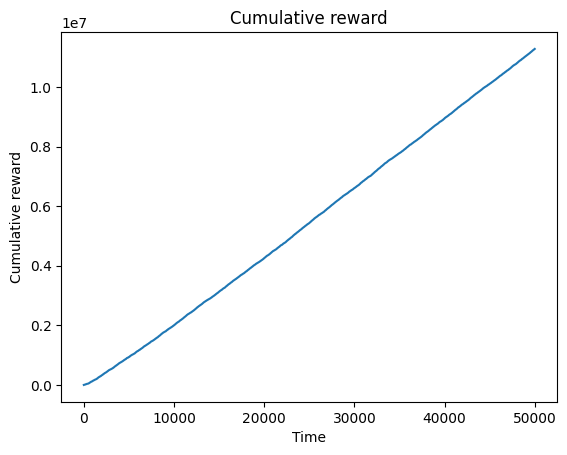

In [127]:
cumulative_rewards_plot(rewards)

In [36]:
def istant_reward_plot(rewards):
    times = [i for i  in range(50000)]
    x_axis = times
    y_axis = rewards
    plt.plot(x_axis, y_axis)
    plt.title('Istant rewards agent')
    plt.xlabel('Time')
    plt.ylabel('Istant rewards')
    plt.show()

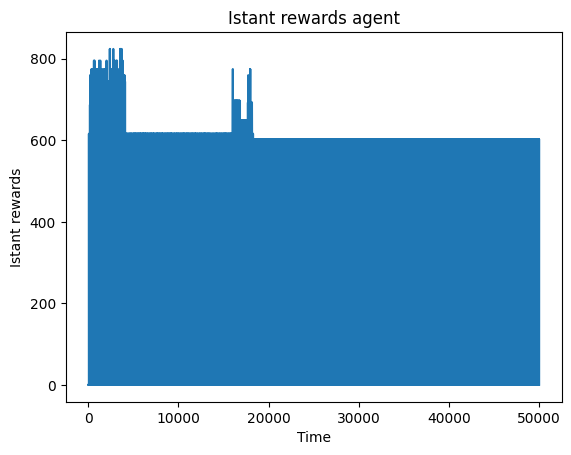

In [38]:
istant_reward_plot(rewards)

In [7]:

import tikzplotlib


def istant_reward__moving_average_plot(rewards):
    times = [i for i  in range(48000)]
    x_axis = times
    y_axis = moving_average(rewards,2001)
    plt.plot(x_axis, y_axis)
    plt.title('Istant rewards agent')
    plt.xlabel('Time')
    plt.ylabel('Istant rewards')
    #plt.show()

    tikzplotlib.save("test.tex")


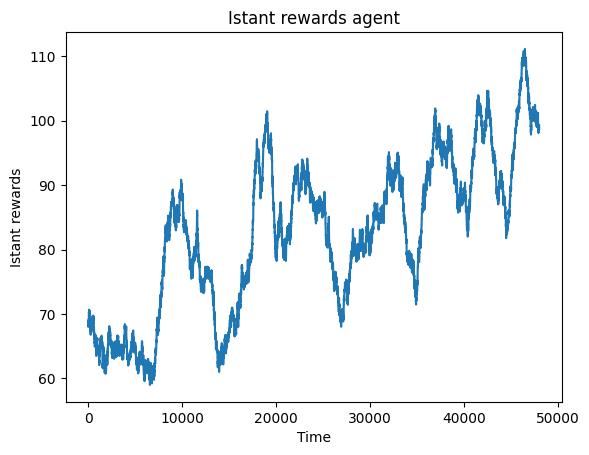

In [8]:
istant_reward__moving_average_plot(rewards)

In [10]:
def istant_reward__moving_average_plot_test(rewards):
    times = [i for i  in range(50000)]
    x_axis = times
    y_axis = [i for i in range(50000)]
    plt.plot(x_axis, y_axis)
    plt.title('Istant rewards agent')
    plt.xlabel('Time')
    plt.ylabel('Istant rewards')
    #plt.show()

    tikzplotlib.save("test1.tex")

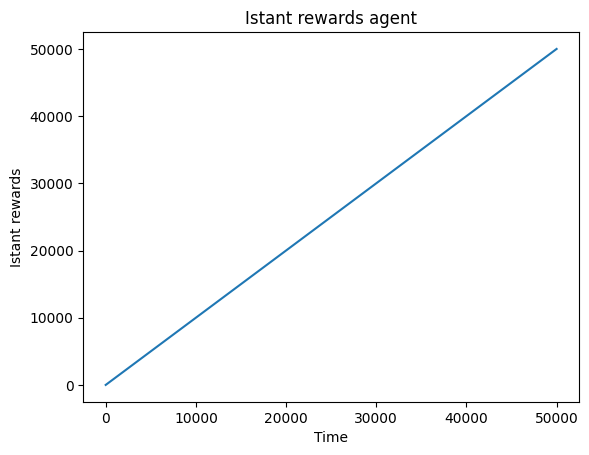

In [11]:
istant_reward__moving_average_plot_test("we")

In [64]:
def plot_ex():
    x = [i for i in range(10)]
    y = [i for i in range(10)]
    plt.plot(x,y,linestyle = "dashed")
    plt.title('CTR evolution')
    plt.xlabel('Time')
    plt.ylabel('CTR')
    tikzplotlib.save("ooo.tex")
    plt.show()



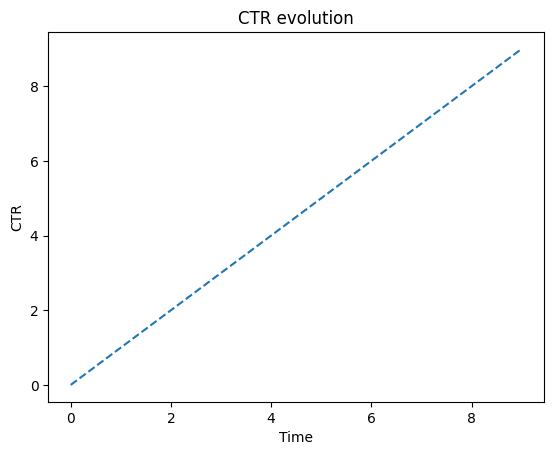

In [65]:
plot_ex()

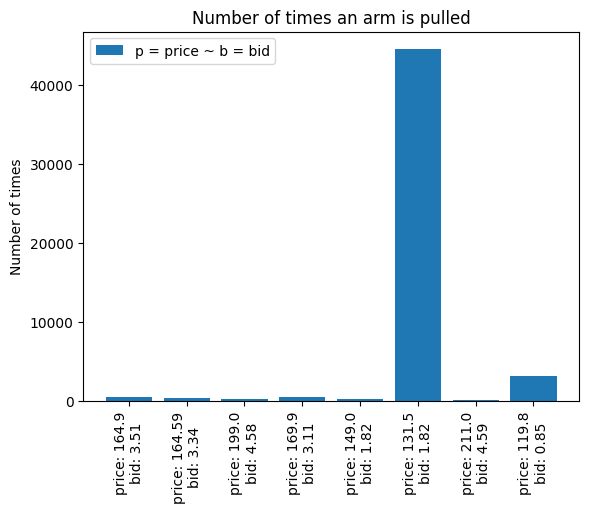

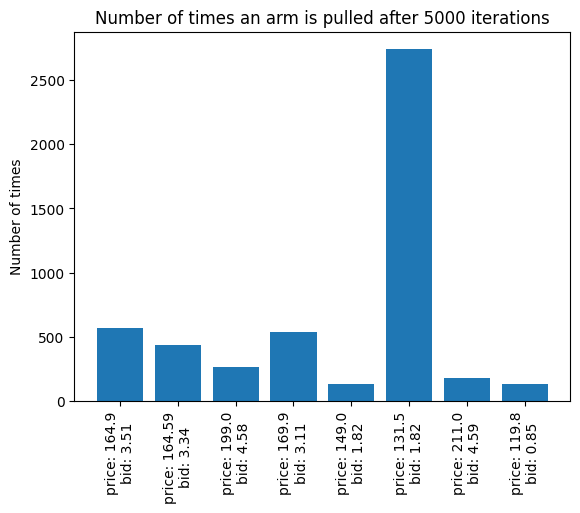

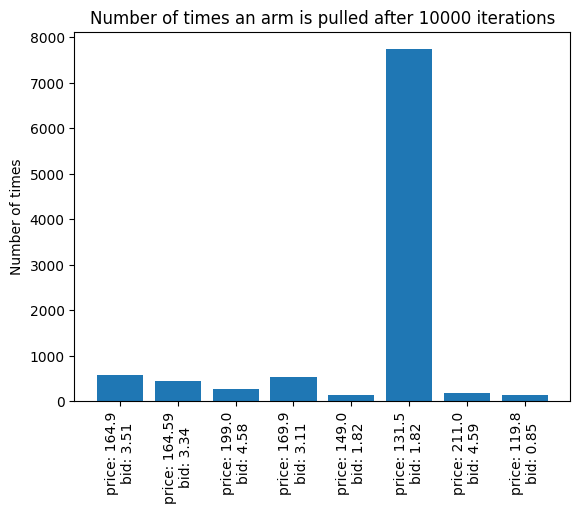

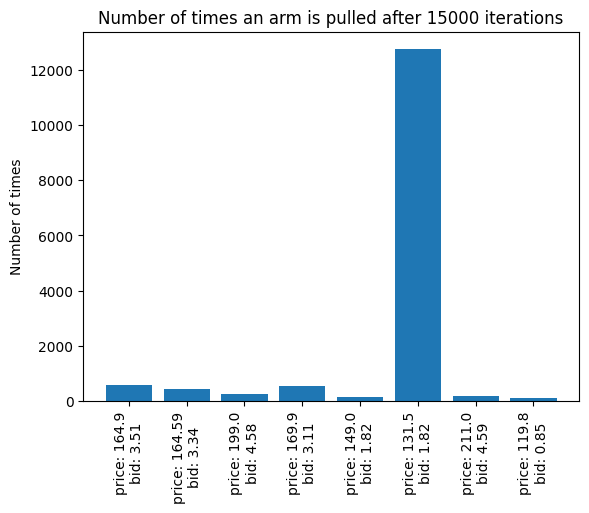

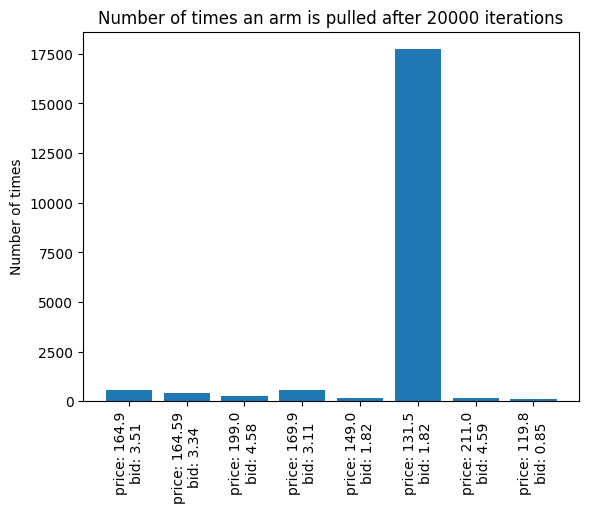

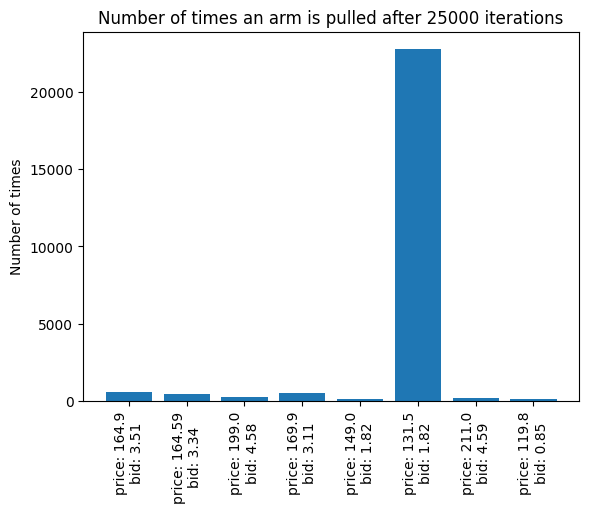

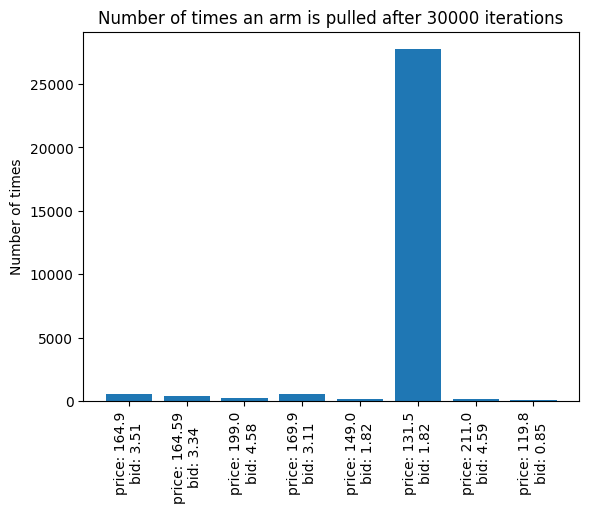

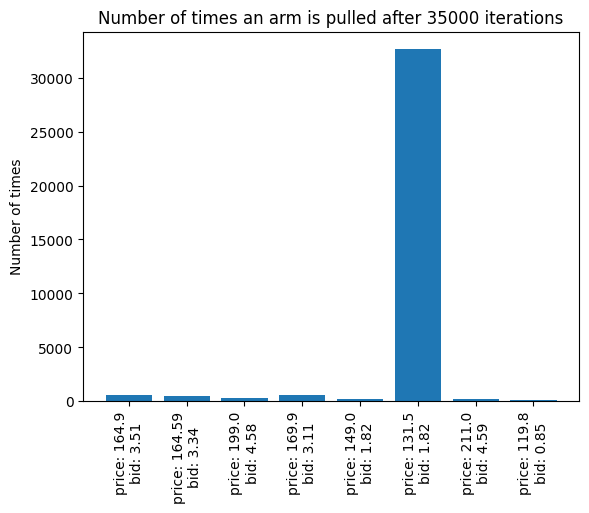

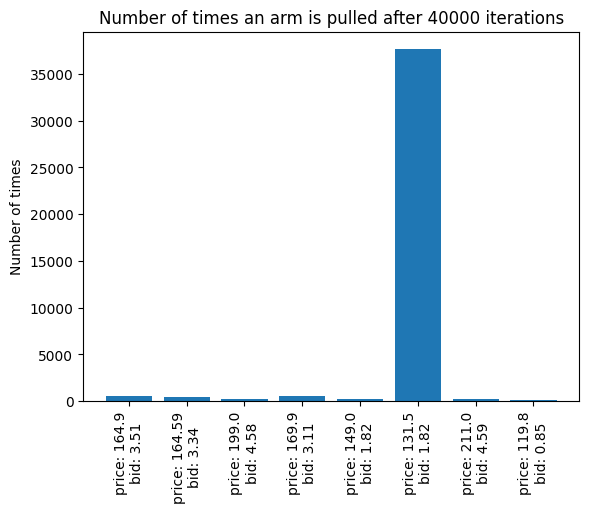

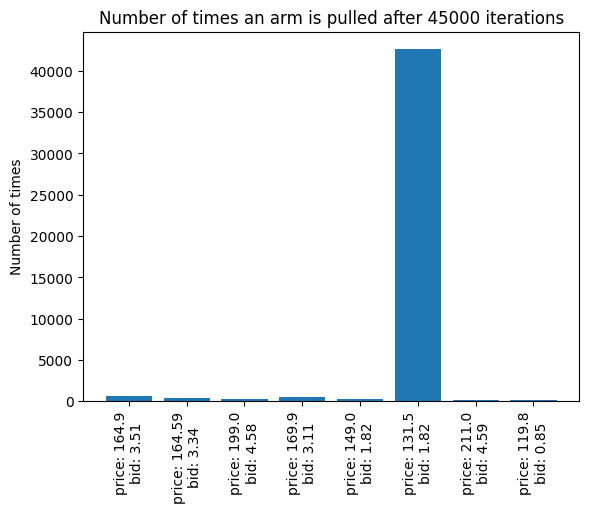

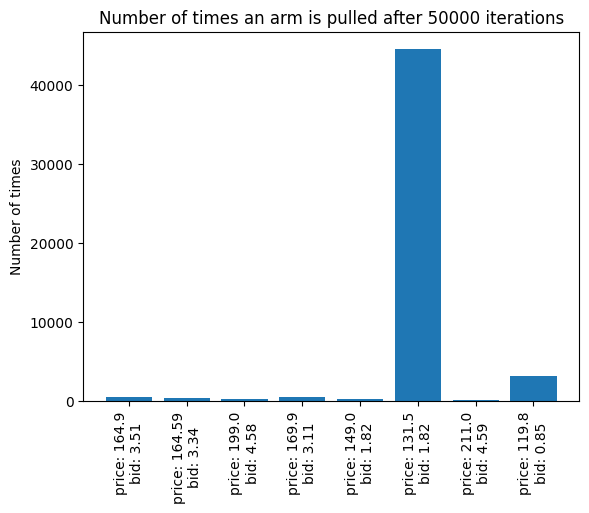

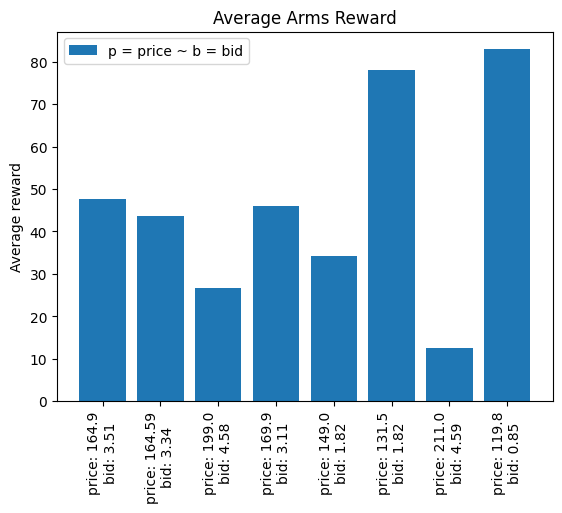

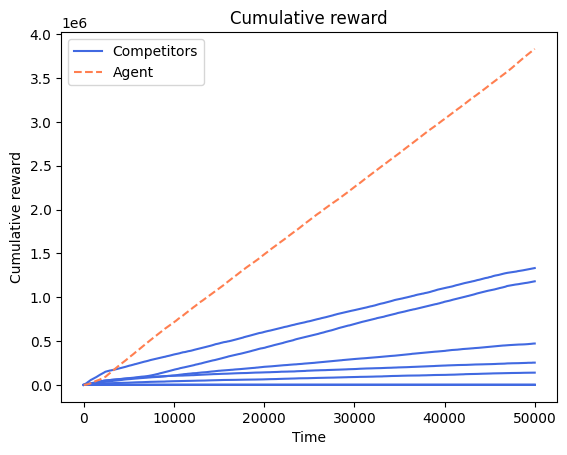

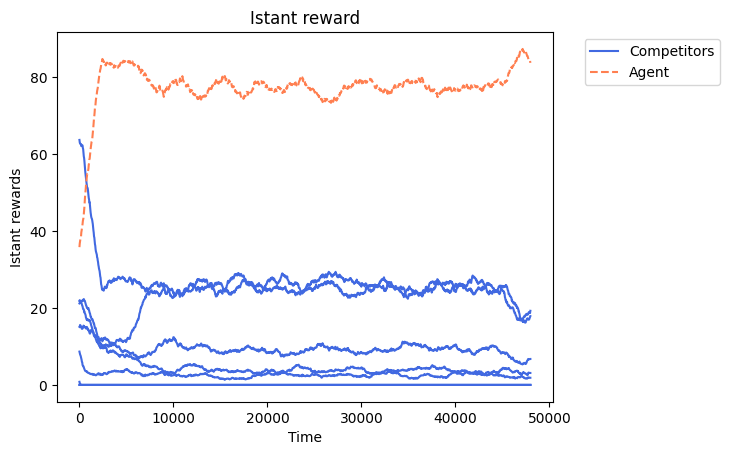

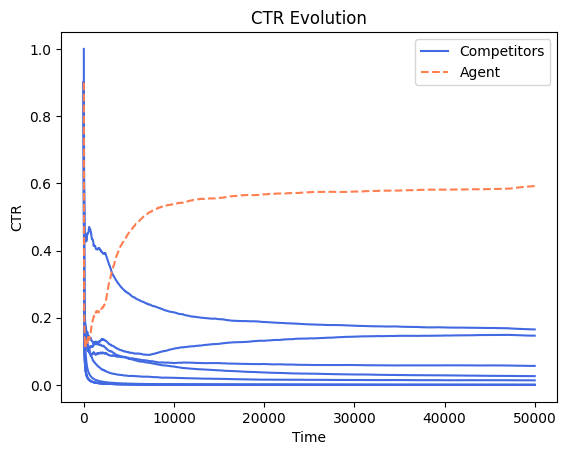

In [5]:
execution("Test_finali/New_algo_2.0_xiaomi_0.6","xiaomi",competitors,agents,chosen_arm,mab0.avg_reward,comp_id_win,rewards,ctr_list)